In [1]:
import numpy as np
import pandas as pd
import datetime as dt

pd.set_option('display.max_rows', 16)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 9.0)
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import gc

In [2]:
plt.rcParams['figure.figsize'] = (16.0, 9.0)

# Data

In [3]:
START = '2008-01-01'
END = '2025-04-30'

In [4]:
# Security Id
stk_info = DataAPI.SecIDGet(assetClass="E",pandas="1")
cond1 = (stk_info['exchangeCD'] == 'XSHE') | (stk_info['exchangeCD'] == 'XSHG')
cond2 = (stk_info['listStatusCD'] == 'L') | (stk_info['listStatusCD'] == 'DE')
cond3 = stk_info['transCurrCD']=='CNY'
stk_info = stk_info[cond1 & cond2 & cond3].copy()
stk_id = stk_info['secID']

In [5]:
stk_id.nunique()

5437

## ST

In [6]:
st_df = DataAPI.SecSTGet(beginDate=START,endDate=END,secID=stk_id,field=['secID','tradeDate','STflg'],pandas="1")
st_df['tradeDate'] = pd.to_datetime(st_df['tradeDate'],format="%Y-%m-%d")

## Risk free rate

In [7]:
shibor_df = DataAPI.MktIborGet(secID="Shibor1M.IRCN",beginDate=START,endDate=END,field=['secID','tradeDate','rate'],pandas="1")
shibor_df['rate'] = shibor_df['rate']*0.01/12
shibor_df['tradeDate'] = pd.to_datetime(shibor_df['tradeDate'])
shibor_df.drop('secID',axis=1,inplace=True)
shibor_df.rename(columns={'rate':'rf'},inplace=True)
shibor_df['ym'] = shibor_df['tradeDate'].dt.to_period('M')
shibor_df.sort_values('tradeDate',inplace=True)
shibor_df_m = shibor_df.groupby('ym',as_index=False).last()
shibor_df_m.drop('tradeDate',axis=1,inplace=True)
shibor_df_m

ym        rf
0    2008-01  0.002949
1    2008-02  0.002946
2    2008-03  0.002746
3    2008-04  0.002862
4    2008-05  0.002953
5    2008-06  0.003113
6    2008-07  0.002806
7    2008-08  0.002681
..       ...       ...
200  2024-09  0.001517
201  2024-10  0.001517
202  2024-11  0.001477
203  2024-12  0.001401
204  2025-01  0.001422
205  2025-02  0.001557
206  2025-03  0.001607
207  2025-04  0.001509

[208 rows x 2 columns]

## Beta

In [8]:
beta_df = pd.read_pickle('./data/beta_df.pkl')
beta_df['tradeDate'] = pd.to_datetime(beta_df['tradeDate'], format="%Y-%m-%d")
beta_df['ym'] = beta_df['tradeDate'].dt.to_period('M')
beta_df['Beta252'] = pd.to_numeric(beta_df['Beta252'])
# Winsorization
# up_q = 0.99999
# lower_q = 0.00001
# beta_df['Beta252_winsor'] = beta_df['Beta252'].clip(lower=beta_df['Beta252'].quantile(lower_q),upper=beta_df['Beta252'].quantile(up_q))
# Monthly
beta_df_m = beta_df.groupby(['secID','ym'],as_index=False)['Beta252'].last()
beta_df_m.rename(columns={'Beta252':'beta'},inplace=True)
beta_df_m

secID       ym    beta
0       000001.XSHE  2008-01  0.9654
1       000001.XSHE  2008-02  1.0292
2       000001.XSHE  2008-03  1.0238
3       000001.XSHE  2008-04  1.0212
4       000001.XSHE  2008-05  1.0697
5       000001.XSHE  2008-06  1.0672
6       000001.XSHE  2008-07  1.0966
7       000001.XSHE  2008-08  1.0386
...             ...      ...     ...
668784  689009.XSHG  2024-09  1.0361
668785  689009.XSHG  2024-10  1.3022
668786  689009.XSHG  2024-11  1.2585
668787  689009.XSHG  2024-12  1.2255
668788  689009.XSHG  2025-01  1.1695
668789  689009.XSHG  2025-02  1.2526
668790  689009.XSHG  2025-03  1.3115
668791  689009.XSHG  2025-04  1.5641

[668792 rows x 3 columns]

## BM

In [9]:
pb_df = pd.read_pickle('./data/pb_df.pkl')
pb_df['tradeDate'] = pd.to_datetime(pb_df['tradeDate'])
pb_df['PB'] = pd.to_numeric(pb_df['PB'])
pb_df['ym'] = pb_df['tradeDate'].dt.to_period('M')
pb_df.sort_values(['secID','tradeDate'],inplace=True)
pb_df = pb_df.groupby(['secID','ym'],as_index=False).last()
pb_df['bm'] = 1 / pb_df['PB']
pb_df.drop(['tradeDate','PB'],axis=1,inplace=True)
pb_df = pb_df[pb_df['bm'] >= 0]
pb_df

secID       ym        bm
0       000001.XSHE  2008-01  0.109513
1       000001.XSHE  2008-02  0.110009
2       000001.XSHE  2008-03  0.201102
3       000001.XSHE  2008-04  0.206701
4       000001.XSHE  2008-05  0.242665
5       000001.XSHE  2008-06  0.304090
6       000001.XSHE  2008-07  0.282598
7       000001.XSHE  2008-08  0.351136
...             ...      ...       ...
668784  689009.XSHG  2024-09  0.162713
668785  689009.XSHG  2024-10  0.190752
668786  689009.XSHG  2024-11  0.189876
668787  689009.XSHG  2024-12  0.177806
668788  689009.XSHG  2025-01  0.164468
668789  689009.XSHG  2025-02  0.147748
668790  689009.XSHG  2025-03  0.129505
668791  689009.XSHG  2025-04  0.134027

[661375 rows x 3 columns]

## Trading data

In [10]:
# %%time
# # About 10 mins
# # # 从优矿下载股票信息，时间较长。由于优矿的限制，每次下载3年的数据

# stk_dict = {}
# begin_ = dt.datetime.strptime(START, '%Y-%m-%d').year
# end_ = dt.datetime.strptime(START, '%Y-%m-%d').year+3
# field = ['secID','tradeDate','preClosePrice','closePrice','negMarketValue','turnoverValue','turnoverRate']
# while begin_ <= 2025:
#     if begin_ == 2025:
#         yesterday = dt.datetime.today() - dt.timedelta(days=1)
#         yesterday.strftime('%Y%m%d')
#         stk_dict[begin_] = DataAPI.MktEqudAdjAfGet(secID=stk_id,
#                                                      beginDate=f'{begin_}0101',
#                                                      endDate=yesterday,
#                                                      field=field,pandas="1")
#     else:
#         stk_dict[begin_] = DataAPI.MktEqudAdjAfGet(secID=stk_id,
#                                                          beginDate=f'{begin_}0101',
#                                                          endDate=f'{end_}1231',
#                                                          field=field,pandas="1")
#     begin_ = end_ + 1
#     end_ = begin_ + 3
    
# for i in range(len(stk_dict)):
#     stk_df = pd.DataFrame(np.vstack([_df for _df in stk_dict.values()]),columns=field)
    
# stk_df.to_pickle('./data/stk_df.pkl')

In [11]:
# stk_df = pd.read_pickle('./data/stk_df.pkl')
# stk_df['tradeDate'] = pd.to_datetime(stk_df['tradeDate'], format='%Y-%m-%d')
# stk_df.sort_values(['secID','tradeDate'],inplace=True)
# # drop ST stocks
# print(stk_df.shape)
# stk_df = pd.merge(stk_df, st_df, on=['secID','tradeDate'],how='left')
# stk_df = stk_df[stk_df['STflg'].isna()].copy()
# stk_df.drop('STflg',axis=1,inplace=True)
# print(stk_df.shape)

In [12]:
# stk_df

In [13]:
# stk_df.info()

In [14]:
# num_cols = ['preClosePrice','closePrice','negMarketValue','turnoverValue','turnoverRate']
# for col in num_cols:
#     stk_df[col] = pd.to_numeric(stk_df[col])

In [15]:
# stk_df.info()

In [16]:
# stk_df

In [17]:
# # # If the trading days are required to be consecutive, fill missing days first. This could possibly produce a much larger df when using 
# ## daily data, and if the missing dates are a lot for some securities

# def fill_missing(df, full_dates, id_col='secID', date_col='tradeDate'):
#     """
#     This function fills the missing dates for stocks.
#     Parameters:
#         df: The dataframe. Could be a sub-dataframe created by "groupby".
#             The dataframe must be sorted on the "date_col".
#         full_dates: the unique dates covering all securities in the full dataframe. 
#                     Need to be sorted.
#         id_col: the security id.
#         date_col: the dates column for the security
#     Returns:
#         A dataframe with the missing dates filled with NA.
#     """
#     stk_id = df[id_col].unique()
#     # Newer version of pandas will allow comparison between "Timestamp" and "datetime64"
# #     date_start = np.where(full_dates == df[date_col].min())[0][0] 
# #     date_end = np.where(full_dates == df[date_col].max())[0][0]
#     date_start = np.where(full_dates == df[date_col].min().to_datetime64())[0][0] 
#     date_end = np.where(full_dates == df[date_col].max().to_datetime64())[0][0]
#     dates = full_dates[date_start:date_end+1]
#     idx = pd.MultiIndex.from_product([stk_id,dates],
#                                      names=(id_col,date_col))
#     df = df.set_index([id_col,date_col]).reindex(idx).reset_index()
#     return df

# full_dates = np.sort(stk_df['tradeDate'].unique())

# full_dates

In [18]:
# %%time
# stk_df = stk_df.groupby('secID').apply(fill_missing, full_dates=full_dates)
# # About 1min

## Amihud (2002) liquidity

Amihud (2002)'s liquidity measure is perhaps the most widely known.

$$ illiq_i = \frac{1}{D} \sum^D_{d=1} \frac{|R_{i,d}|}{VOLD_{i,d}} $$

VOLD: the dollar volume, measured as "close_price * shares_traded"

Intuition: the effect of volume on moving prices. If a small volume moves price significantly (nonsignificantly), the stock is quite illiquid (liquid).

Period choices: Amihud(2002) uses t-11 month through t month (12 months) daily data as the measure for month t. 

Let's use the two measures: 
- Amihud's original measure, but we do not stick to calendar month. Let's use 250 trading days.
- a simple one: one-month daily data.

Also, let's use the actual dollar volume within one day

- Acharya and Pedersen (2005): liquidity should be positively correlated with contemporaneous returns, and negatively with future returns
- 其他相关文献， Bali, Peng, Shen, and Tang (2014)，Chordia, Roll and Subrahmanyam (2000)
- Pastor and Stambaugh (2003): Aggregate liquidity factor.

In [19]:
# stk_df

In [20]:
# stk_df.reset_index(drop=True, inplace=True)

# stk_df['ret_daily'] = stk_df['closePrice'] / stk_df['preClosePrice'] - 1
# stk_df['illiq_daily'] = abs(stk_df['ret_daily'].values) / stk_df['turnoverValue'].values
# stk_df.loc[np.isinf(stk_df['illiq_daily']),'illiq_daily'] = np.nan
# stk_df['ym'] = stk_df['tradeDate'].dt.to_period('M')

# stk_df.to_pickle('./data/stk_df_filled.pkl')

In [21]:
stk_df = pd.read_pickle('./data/stk_df_filled.pkl')

In [22]:
stk_df

secID  tradeDate  preClosePrice  closePrice  negMarketValue  \
0         000001.XSHE 2008-01-02       1221.497    1201.877    6.672404e+10   
1         000001.XSHE 2008-01-03       1201.877    1181.940    6.561725e+10   
2         000001.XSHE 2008-01-04       1181.940    1214.218    6.740920e+10   
3         000001.XSHE 2008-01-07       1214.218    1239.534    6.881466e+10   
4         000001.XSHE 2008-01-08       1239.534    1278.141    7.095798e+10   
5         000001.XSHE 2008-01-09       1278.141    1300.926    7.222289e+10   
6         000001.XSHE 2008-01-10       1300.926    1327.507    7.369862e+10   
7         000001.XSHE 2008-01-11       1327.507    1394.911    7.744065e+10   
...               ...        ...            ...         ...             ...   
13182725  689009.XSHG 2025-03-26         62.447      62.437    3.408568e+10   
13182726  689009.XSHG 2025-03-27         62.437      65.760    3.589992e+10   
13182727  689009.XSHG 2025-03-28         65.760      65.609    3.581745e+10   
13182728  689009.XSHG 2025-03-31         65.609      65.659    3.584494e+10   
13182729  689009.XSHG 2025-04-01         65.659      64.411    3.516323e+10   
13182730  689009.XSHG 2025-04-02         64.411      64.149    3.502029e+10   
13182731  689009.XSHG 2025-04-03         64.149      63.444    3.463545e+10   
13182732  689009.XSHG 2025-04-07         63.444      53.665    2.929719e+10   

          turnoverValue  turnoverRate  ret_daily   illiq_daily       ym  
0          7.634657e+08        0.0114  -0.016062  2.103861e-11  2008-01  
1          1.023423e+09        0.0157  -0.016588  1.620857e-11  2008-01  
2          7.621612e+08        0.0113   0.027309  3.583145e-11  2008-01  
3          1.236910e+09        0.0179   0.020850  1.685622e-11  2008-01  
4          2.029248e+09        0.0285   0.031146  1.534873e-11  2008-01  
5          7.863130e+08        0.0110   0.017827  2.267122e-11  2008-01  
6          1.016738e+09        0.0139   0.020432  2.009601e-11  2008-01  
7          1.555168e+09        0.0204   0.050775  3.264912e-11  2008-01  
...                 ...           ...        ...           ...      ...  
13182725   2.834881e+08        0.0083  -0.000160  5.648766e-13  2025-03  
13182726   6.975345e+08        0.0197   0.053222  7.629967e-11  2025-03  
13182727   3.724902e+08        0.0104  -0.002296  6.164534e-12  2025-03  
13182728   5.167717e+08        0.0144   0.000762  1.474714e-12  2025-03  
13182729   4.671283e+08        0.0133  -0.019007  4.068967e-11  2025-04  
13182730   2.618055e+08        0.0075  -0.004068  1.553683e-11  2025-04  
13182731   1.100406e+09        0.0334  -0.010990  9.987255e-12  2025-04  
13182732   1.006334e+09        0.0336  -0.154136  1.531658e-10  2025-04  

[13182733 rows x 10 columns]

In [23]:
stk_df.loc[np.isinf(stk_df['illiq_daily'])]

Empty DataFrame
Columns: [secID, tradeDate, preClosePrice, closePrice, negMarketValue, turnoverValue, turnoverRate, ret_daily, illiq_daily, ym]
Index: []

In [24]:
stk_df[(stk_df['secID']=='000001.XSHE') & (stk_df['tradeDate']>='2010-06-01') & (stk_df['tradeDate']<='2010-09-05')]

secID  tradeDate  preClosePrice  closePrice  negMarketValue  \
589  000001.XSHE 2010-06-01        722.475     713.810    5.058718e+10   
590  000001.XSHE 2010-06-02        713.810     710.922    5.038249e+10   
591  000001.XSHE 2010-06-03        710.922     710.509    5.035325e+10   
592  000001.XSHE 2010-06-04        710.509     713.810    5.058718e+10   
593  000001.XSHE 2010-06-07        713.810     697.718    4.944677e+10   
594  000001.XSHE 2010-06-08        697.718     689.054    4.883271e+10   
595  000001.XSHE 2010-06-09        689.054     729.077    5.166910e+10   
596  000001.XSHE 2010-06-10        729.077     705.971    5.003160e+10   
..           ...        ...            ...         ...             ...   
647  000001.XSHE 2010-08-25        722.475     722.475    5.437499e+10   
648  000001.XSHE 2010-08-26        722.475     722.475    5.437499e+10   
649  000001.XSHE 2010-08-27        722.475     722.475    5.437499e+10   
650  000001.XSHE 2010-08-30        722.475     722.475    5.437499e+10   
651  000001.XSHE 2010-08-31        722.475     722.475    5.437499e+10   
652  000001.XSHE 2010-09-01        722.475     722.475    5.437499e+10   
653  000001.XSHE 2010-09-02        722.475     750.532    5.648664e+10   
654  000001.XSHE 2010-09-03        750.532     732.790    5.515133e+10   

     turnoverValue  turnoverRate  ret_daily   illiq_daily       ym  
589   3.790589e+08        0.0075  -0.011993  3.164019e-11  2010-06  
590   4.307207e+08        0.0086  -0.004046  9.393313e-12  2010-06  
591   5.011432e+08        0.0098  -0.000581  1.159221e-12  2010-06  
592   2.328248e+08        0.0046   0.004646  1.995477e-11  2010-06  
593   4.105509e+08        0.0083  -0.022544  5.491113e-11  2010-06  
594   2.861562e+08        0.0058  -0.012418  4.339457e-11  2010-06  
595   8.579786e+08        0.0170   0.058084  6.769864e-11  2010-06  
596   4.895630e+08        0.0097  -0.031692  6.473554e-11  2010-06  
..             ...           ...        ...           ...      ...  
647   0.000000e+00        0.0000   0.000000           NaN  2010-08  
648   0.000000e+00        0.0000   0.000000           NaN  2010-08  
649   0.000000e+00        0.0000   0.000000           NaN  2010-08  
650   0.000000e+00        0.0000   0.000000           NaN  2010-08  
651   0.000000e+00        0.0000   0.000000           NaN  2010-08  
652   0.000000e+00        0.0000   0.000000           NaN  2010-09  
653   2.984709e+09        0.0526   0.038835  1.301117e-11  2010-09  
654   1.110874e+09        0.0201  -0.023639  2.127986e-11  2010-09  

[66 rows x 10 columns]

### Monthly trading data

In [25]:
stk_df_m = stk_df.groupby(['secID','ym'],as_index=False).last()

In [26]:
stk_df_m

secID       ym  tradeDate  preClosePrice  closePrice  \
0       000001.XSHE  2008-01 2008-01-31       1074.347    1053.778   
1       000001.XSHE  2008-02 2008-02-29       1037.956    1049.032   
2       000001.XSHE  2008-03 2008-03-31        918.971     892.389   
3       000001.XSHE  2008-04 2008-04-30        884.478     937.325   
4       000001.XSHE  2008-05 2008-05-30        789.543     798.403   
5       000001.XSHE  2008-06 2008-06-30        615.179     611.698   
6       000001.XSHE  2008-07 2008-07-31        681.317     658.216   
7       000001.XSHE  2008-08 2008-08-29        635.115     639.229   
...             ...      ...        ...            ...         ...   
657913  689009.XSHG  2024-09 2024-09-30         43.333      48.540   
657914  689009.XSHG  2024-10 2024-10-31         44.904      44.612   
657915  689009.XSHG  2024-11 2024-11-29         43.434      44.813   
657916  689009.XSHG  2024-12 2024-12-31         48.469      47.835   
657917  689009.XSHG  2025-01 2025-01-27         53.514      51.702   
657918  689009.XSHG  2025-02 2025-02-28         58.409      57.553   
657919  689009.XSHG  2025-03 2025-03-31         65.609      65.659   
657920  689009.XSHG  2025-04 2025-04-07         63.444      53.665   

        negMarketValue  turnoverValue  turnoverRate  ret_daily   illiq_daily  
0         5.850212e+10   5.328429e+08        0.0089  -0.019146  3.593101e-11  
1         5.823860e+10   2.267900e+08        0.0039   0.010671  4.705222e-11  
2         4.954234e+10   6.155862e+08        0.0123  -0.028926  4.698908e-11  
3         5.203702e+10   9.029705e+08        0.0176   0.059749  6.616979e-11  
4         4.432458e+10   2.049950e+08        0.0046   0.011222  5.474125e-11  
5         4.140495e+10   3.618398e+08        0.0088  -0.005659  1.563818e-11  
6         4.455369e+10   2.188600e+08        0.0048  -0.033906  1.549227e-10  
7         4.326849e+10   3.096257e+08        0.0071   0.006478  2.092064e-11  
...                ...            ...           ...        ...           ...  
657913    2.633272e+10   1.248639e+09        0.0490   0.120162  9.623476e-11  
657914    2.420206e+10   3.709377e+08        0.0153  -0.006503  1.753060e-11  
657915    2.431436e+10   4.117342e+08        0.0170   0.031749  7.711121e-11  
657916    2.610548e+10   3.727989e+08        0.0142  -0.013081  3.508735e-11  
657917    2.822514e+10   6.545678e+08        0.0236  -0.033860  5.172925e-11  
657918    3.141930e+10   5.978337e+08        0.0190  -0.014655  2.451397e-11  
657919    3.584494e+10   5.167717e+08        0.0144   0.000762  1.474714e-12  
657920    2.929719e+10   1.006334e+09        0.0336  -0.154136  1.531658e-10  

[657921 rows x 10 columns]

In [27]:
stk_df_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 657921 entries, 0 to 657920
Data columns (total 10 columns):
secID             657921 non-null object
ym                657921 non-null period[M]
tradeDate         657921 non-null datetime64[ns]
preClosePrice     643402 non-null float64
closePrice        643402 non-null float64
negMarketValue    643402 non-null float64
turnoverValue     643402 non-null float64
turnoverRate      643402 non-null float64
ret_daily         643402 non-null float64
illiq_daily       633079 non-null float64
dtypes: datetime64[ns](1), float64(7), object(1), period[M](1)
memory usage: 55.2+ MB


In [28]:
stk_df_m.groupby('secID')['closePrice'].apply(lambda x: x / x.shift() - 1)

0              NaN
1        -0.004504
2        -0.149321
3         0.050355
4        -0.148211
5        -0.233848
6         0.076047
7        -0.028846
            ...   
657913    0.078307
657914   -0.080923
657915    0.004506
657916    0.067436
657917    0.080840
657918    0.113168
657919    0.140844
657920   -0.182671
Name: closePrice, Length: 657921, dtype: float64

### 新股上市处理

In [29]:
# stk_df_m_inclIPO = stk_df_m.copy()

In [30]:
list_date = stk_info[['secID','listDate']].copy()
list_date['listDate'] = pd.to_datetime(list_date['listDate'],format="%Y-%m-%d")
list_date['listMonth'] = list_date['listDate'].dt.to_period('M')
# list_date

stk_df_m = pd.merge(stk_df_m,list_date[['secID','listMonth']],on='secID')
# stk_df_m

stk_listMonth = stk_df_m.groupby('secID')[['ym','listMonth']].first()
stk_listMonth['listm_dist'] = stk_listMonth['ym'] - stk_listMonth['listMonth']
# pandas 版本太久
stk_listMonth['listm_dist'] = stk_listMonth['listm_dist'].apply(lambda x: x.n)

# 上市日期在样本内的新上市股票
stk_listMonth.loc[stk_listMonth['listm_dist'] < 1]

newlist_secID = stk_listMonth.loc[stk_listMonth['listm_dist'] < 1].index
newlist_secID

# 每只股票丢掉第一个观测值
temp = stk_df_m.loc[stk_df_m['secID'].isin(newlist_secID)].groupby('secID').apply(lambda x: x.iloc[1:]).drop('secID',axis=1).reset_index().drop('level_1',axis=1)

stk_df_m = pd.concat([stk_df_m.loc[~stk_df_m['secID'].isin(newlist_secID)],temp],axis=0).reset_index(drop=True)

# stk_df_m.drop('listMonth',axis=1,inplace=True)
stk_df_m = stk_df_m.sort_values(['secID', 'ym']).reset_index(drop=True)
stk_df_m

secID       ym  tradeDate  preClosePrice  closePrice  \
0       000001.XSHE  2008-01 2008-01-31       1074.347    1053.778   
1       000001.XSHE  2008-02 2008-02-29       1037.956    1049.032   
2       000001.XSHE  2008-03 2008-03-31        918.971     892.389   
3       000001.XSHE  2008-04 2008-04-30        884.478     937.325   
4       000001.XSHE  2008-05 2008-05-30        789.543     798.403   
5       000001.XSHE  2008-06 2008-06-30        615.179     611.698   
6       000001.XSHE  2008-07 2008-07-31        681.317     658.216   
7       000001.XSHE  2008-08 2008-08-29        635.115     639.229   
...             ...      ...        ...            ...         ...   
654067  689009.XSHG  2024-09 2024-09-30         43.333      48.540   
654068  689009.XSHG  2024-10 2024-10-31         44.904      44.612   
654069  689009.XSHG  2024-11 2024-11-29         43.434      44.813   
654070  689009.XSHG  2024-12 2024-12-31         48.469      47.835   
654071  689009.XSHG  2025-01 2025-01-27         53.514      51.702   
654072  689009.XSHG  2025-02 2025-02-28         58.409      57.553   
654073  689009.XSHG  2025-03 2025-03-31         65.609      65.659   
654074  689009.XSHG  2025-04 2025-04-07         63.444      53.665   

        negMarketValue  turnoverValue  turnoverRate  ret_daily   illiq_daily  \
0         5.850212e+10   5.328429e+08        0.0089  -0.019146  3.593101e-11   
1         5.823860e+10   2.267900e+08        0.0039   0.010671  4.705222e-11   
2         4.954234e+10   6.155862e+08        0.0123  -0.028926  4.698908e-11   
3         5.203702e+10   9.029705e+08        0.0176   0.059749  6.616979e-11   
4         4.432458e+10   2.049950e+08        0.0046   0.011222  5.474125e-11   
5         4.140495e+10   3.618398e+08        0.0088  -0.005659  1.563818e-11   
6         4.455369e+10   2.188600e+08        0.0048  -0.033906  1.549227e-10   
7         4.326849e+10   3.096257e+08        0.0071   0.006478  2.092064e-11   
...                ...            ...           ...        ...           ...   
654067    2.633272e+10   1.248639e+09        0.0490   0.120162  9.623476e-11   
654068    2.420206e+10   3.709377e+08        0.0153  -0.006503  1.753060e-11   
654069    2.431436e+10   4.117342e+08        0.0170   0.031749  7.711121e-11   
654070    2.610548e+10   3.727989e+08        0.0142  -0.013081  3.508735e-11   
654071    2.822514e+10   6.545678e+08        0.0236  -0.033860  5.172925e-11   
654072    3.141930e+10   5.978337e+08        0.0190  -0.014655  2.451397e-11   
654073    3.584494e+10   5.167717e+08        0.0144   0.000762  1.474714e-12   
654074    2.929719e+10   1.006334e+09        0.0336  -0.154136  1.531658e-10   

       listMonth  
0        1991-04  
1        1991-04  
2        1991-04  
3        1991-04  
4        1991-04  
5        1991-04  
6        1991-04  
7        1991-04  
...          ...  
654067   2020-10  
654068   2020-10  
654069   2020-10  
654070   2020-10  
654071   2020-10  
654072   2020-10  
654073   2020-10  
654074   2020-10  

[654075 rows x 11 columns]

In [31]:
# 随机检查
stk_df_m[stk_df_m['secID']==np.random.choice(stk_df_m['secID'],1)[0]]

secID       ym  tradeDate  preClosePrice  closePrice  \
405617  600173.XSHG  2008-02 2008-02-29         15.409      16.023   
405618  600173.XSHG  2008-03 2008-03-31         10.576      10.225   
405619  600173.XSHG  2008-04 2008-04-30          9.304       9.776   
405620  600173.XSHG  2008-05 2008-05-30         10.411      10.620   
405621  600173.XSHG  2008-06 2008-06-30          6.280       6.356   
405622  600173.XSHG  2008-07 2008-07-31          7.452       7.124   
405623  600173.XSHG  2008-08 2008-08-29          5.250       5.414   
405624  600173.XSHG  2008-09 2008-09-26          5.107       5.282   
...             ...      ...        ...            ...         ...   
405816  600173.XSHG  2024-09 2024-09-30         10.498      11.273   
405817  600173.XSHG  2024-10 2024-10-31         10.349      10.573   
405818  600173.XSHG  2024-11 2024-11-29         11.273      11.248   
405819  600173.XSHG  2024-12 2024-12-31         10.049       9.899   
405820  600173.XSHG  2025-01 2025-01-27         10.648      10.598   
405821  600173.XSHG  2025-02 2025-02-28         16.198      15.748   
405822  600173.XSHG  2025-03 2025-03-31         15.698      17.223   
405823  600173.XSHG  2025-04 2025-04-07         18.497      16.648   

        negMarketValue  turnoverValue  turnoverRate  ret_daily   illiq_daily  \
405617    1.558364e+09    284902912.0        0.1777   0.039847  1.398611e-10   
405618    9.944966e+08      8816645.0        0.0087  -0.033188  3.764283e-09   
405619    9.507942e+08     23783544.0        0.0253   0.050731  2.133024e-09   
405620    1.032869e+09     18700260.0        0.0183   0.020075  1.073510e-09   
405621    6.182294e+08      3905092.0        0.0064   0.012102  3.099008e-09   
405622    6.928433e+08      8469822.0        0.0121  -0.044015  5.196689e-09   
405623    5.265609e+08      4453215.0        0.0085   0.031238  7.014729e-09   
405624    5.137699e+08     14001487.0        0.0278   0.034267  2.447361e-09   
...                ...            ...           ...        ...           ...   
405816    3.158877e+09    108141502.0        0.0349   0.073824  6.826573e-10   
405817    2.962761e+09     47967095.0        0.0162   0.021645  4.512386e-10   
405818    3.151873e+09     44828739.0        0.0142  -0.002218  4.947024e-11   
405819    2.773648e+09     28174046.0        0.0101  -0.014927  5.298088e-10   
405820    2.969765e+09     45788604.0        0.0153  -0.004696  1.025521e-10   
405821    4.412622e+09    142617849.0        0.0318  -0.027781  1.947947e-10   
405822    4.825868e+09    261022866.0        0.0552   0.097146  3.721748e-10   
405823    4.664772e+09    310938119.0        0.0638  -0.099962  3.214857e-10   

       listMonth  
405617   1999-04  
405618   1999-04  
405619   1999-04  
405620   1999-04  
405621   1999-04  
405622   1999-04  
405623   1999-04  
405624   1999-04  
...          ...  
405816   1999-04  
405817   1999-04  
405818   1999-04  
405819   1999-04  
405820   1999-04  
405821   1999-04  
405822   1999-04  
405823   1999-04  

[207 rows x 11 columns]

In [32]:
stk_df_m.groupby('secID',as_index=False)['closePrice'].apply(lambda x: x / x.shift() - 1)

0     0              NaN
      1        -0.004504
      2        -0.149321
      3         0.050355
      4        -0.148211
      5        -0.233848
      6         0.076047
      7        -0.028846
                  ...   
5371  654067    0.078307
      654068   -0.080923
      654069    0.004506
      654070    0.067436
      654071    0.080840
      654072    0.113168
      654073    0.140844
      654074   -0.182671
Name: closePrice, Length: 654075, dtype: float64

In [33]:
stk_df_m['ret'] = stk_df_m.groupby('secID')['closePrice'].apply(lambda x: x / x.shift() - 1)
stk_df_m['size'] = np.log(stk_df_m['negMarketValue'])
stk_df_m.drop(['preClosePrice'],axis=1,inplace=True)
stk_df_m = pd.merge(stk_df_m, shibor_df_m, on='ym')
stk_df_m['exret'] = stk_df_m['ret'] - stk_df_m['rf']
stk_df_m.sort_values(['secID','ym'],inplace=True)
stk_df_m.rename(columns={'negMarketValue':'mktcap'},inplace=True)
stk_df_m

secID       ym  tradeDate  closePrice        mktcap  \
0       000001.XSHE  2008-01 2008-01-31    1053.778  5.850212e+10   
1339    000001.XSHE  2008-02 2008-02-29    1049.032  5.823860e+10   
2690    000001.XSHE  2008-03 2008-03-31     892.389  4.954234e+10   
4060    000001.XSHE  2008-04 2008-04-30     937.325  5.203702e+10   
5440    000001.XSHE  2008-05 2008-05-30     798.403  4.432458e+10   
6837    000001.XSHE  2008-06 2008-06-30     611.698  4.140495e+10   
8265    000001.XSHE  2008-07 2008-07-31     658.216  4.455369e+10   
9707    000001.XSHE  2008-08 2008-08-29     639.229  4.326849e+10   
...             ...      ...        ...         ...           ...   
619119  689009.XSHG  2024-09 2024-09-30      48.540  2.633272e+10   
624098  689009.XSHG  2024-10 2024-10-31      44.612  2.420206e+10   
629084  689009.XSHG  2024-11 2024-11-29      44.813  2.431436e+10   
634072  689009.XSHG  2024-12 2024-12-31      47.835  2.610548e+10   
639066  689009.XSHG  2025-01 2025-01-27      51.702  2.822514e+10   
644069  689009.XSHG  2025-02 2025-02-28      57.553  3.141930e+10   
649071  689009.XSHG  2025-03 2025-03-31      65.659  3.584494e+10   
654074  689009.XSHG  2025-04 2025-04-07      53.665  2.929719e+10   

        turnoverValue  turnoverRate  ret_daily   illiq_daily listMonth  \
0        5.328429e+08        0.0089  -0.019146  3.593101e-11   1991-04   
1339     2.267900e+08        0.0039   0.010671  4.705222e-11   1991-04   
2690     6.155862e+08        0.0123  -0.028926  4.698908e-11   1991-04   
4060     9.029705e+08        0.0176   0.059749  6.616979e-11   1991-04   
5440     2.049950e+08        0.0046   0.011222  5.474125e-11   1991-04   
6837     3.618398e+08        0.0088  -0.005659  1.563818e-11   1991-04   
8265     2.188600e+08        0.0048  -0.033906  1.549227e-10   1991-04   
9707     3.096257e+08        0.0071   0.006478  2.092064e-11   1991-04   
...               ...           ...        ...           ...       ...   
619119   1.248639e+09        0.0490   0.120162  9.623476e-11   2020-10   
624098   3.709377e+08        0.0153  -0.006503  1.753060e-11   2020-10   
629084   4.117342e+08        0.0170   0.031749  7.711121e-11   2020-10   
634072   3.727989e+08        0.0142  -0.013081  3.508735e-11   2020-10   
639066   6.545678e+08        0.0236  -0.033860  5.172925e-11   2020-10   
644069   5.978337e+08        0.0190  -0.014655  2.451397e-11   2020-10   
649071   5.167717e+08        0.0144   0.000762  1.474714e-12   2020-10   
654074   1.006334e+09        0.0336  -0.154136  1.531658e-10   2020-10   

             ret       size        rf     exret  
0            NaN  24.792329  0.002949       NaN  
1339   -0.004504  24.787814  0.002946 -0.007450  
2690   -0.149321  24.626093  0.002746 -0.152068  
4060    0.050355  24.675221  0.002862  0.047493  
5440   -0.148211  24.514805  0.002953 -0.151164  
6837   -0.233848  24.446666  0.003113 -0.236961  
8265    0.076047  24.519961  0.002806  0.073241  
9707   -0.028846  24.490690  0.002681 -0.031527  
...          ...        ...       ...       ...  
619119  0.078307  23.994078  0.001517  0.076791  
624098 -0.080923  23.909704  0.001517 -0.082440  
629084  0.004506  23.914333  0.001477  0.003029  
634072  0.067436  23.985411  0.001401  0.066035  
639066  0.080840  24.063479  0.001422  0.079419  
644069  0.113168  24.170688  0.001557  0.111611  
649071  0.140844  24.302468  0.001607  0.139237  
654074 -0.182671  24.100757  0.001509 -0.184180  

[654075 rows x 14 columns]

### Momentum and reversal

#### Using unfilled data 

In [34]:
stk_unfilled_df = pd.read_pickle('./data/stk_df.pkl')
stk_unfilled_df['tradeDate'] = pd.to_datetime(stk_unfilled_df['tradeDate'], format='%Y-%m-%d')
stk_unfilled_df['ym'] = stk_unfilled_df['tradeDate'].dt.to_period('M')
stk_unfilled_df.sort_values(['secID','tradeDate'],inplace=True)
# drop ST stocks
print(stk_unfilled_df.shape)
stk_unfilled_df = pd.merge(stk_unfilled_df, st_df, on=['secID','tradeDate'],how='left')
stk_unfilled_df = stk_unfilled_df[stk_unfilled_df['STflg'].isna()].copy()
stk_unfilled_df.drop('STflg',axis=1,inplace=True)
print(stk_unfilled_df.shape)
# Monthly
stk_unfilled_df_m = stk_unfilled_df.groupby(['secID','ym'],as_index=False).last()

(13411003, 8)
(12878387, 8)


In [35]:
stk_unfilled_df_m

secID       ym  tradeDate  preClosePrice  closePrice  \
0       000001.XSHE  2008-01 2008-01-31       1074.347    1053.778   
1       000001.XSHE  2008-02 2008-02-29       1037.956    1049.032   
2       000001.XSHE  2008-03 2008-03-31        918.971     892.389   
3       000001.XSHE  2008-04 2008-04-30        884.478     937.325   
4       000001.XSHE  2008-05 2008-05-30        789.543     798.403   
5       000001.XSHE  2008-06 2008-06-30        615.179     611.698   
6       000001.XSHE  2008-07 2008-07-31        681.317     658.216   
7       000001.XSHE  2008-08 2008-08-29        635.115     639.229   
...             ...      ...        ...            ...         ...   
643394  689009.XSHG  2024-09 2024-09-30         43.333      48.540   
643395  689009.XSHG  2024-10 2024-10-31         44.904      44.612   
643396  689009.XSHG  2024-11 2024-11-29         43.434      44.813   
643397  689009.XSHG  2024-12 2024-12-31         48.469      47.835   
643398  689009.XSHG  2025-01 2025-01-27         53.514      51.702   
643399  689009.XSHG  2025-02 2025-02-28         58.409      57.553   
643400  689009.XSHG  2025-03 2025-03-31         65.609      65.659   
643401  689009.XSHG  2025-04 2025-04-07         63.444      53.665   

        negMarketValue  turnoverValue  turnoverRate  
0         5.850212e+10   5.328429e+08        0.0089  
1         5.823860e+10   2.267900e+08        0.0039  
2         4.954234e+10   6.155862e+08        0.0123  
3         5.203702e+10   9.029705e+08        0.0176  
4         4.432458e+10   2.049950e+08        0.0046  
5         4.140495e+10   3.618398e+08        0.0088  
6         4.455369e+10   2.188600e+08        0.0048  
7         4.326849e+10   3.096257e+08        0.0071  
...                ...            ...           ...  
643394    2.633272e+10   1.248639e+09        0.0490  
643395    2.420206e+10   3.709377e+08        0.0153  
643396    2.431436e+10   4.117342e+08        0.0170  
643397    2.610548e+10   3.727989e+08        0.0142  
643398    2.822514e+10   6.545678e+08        0.0236  
643399    3.141930e+10   5.978337e+08        0.0190  
643400    3.584494e+10   5.167717e+08        0.0144  
643401    2.929719e+10   1.006334e+09        0.0336  

[643402 rows x 8 columns]

#### 新股处理

In [36]:
stk_unfilled_df_m = pd.merge(stk_unfilled_df_m,list_date[['secID','listMonth']],on='secID')
# stk_unfilled_df_m
stk_listMonth = stk_unfilled_df_m.groupby('secID')[['ym','listMonth']].first()
stk_listMonth['listm_dist'] = stk_listMonth['ym'] - stk_listMonth['listMonth']
# pandas 版本太久
stk_listMonth['listm_dist'] = stk_listMonth['listm_dist'].apply(lambda x: x.n)

# 上市日期在样本内的新上市股票
stk_listMonth.loc[stk_listMonth['listm_dist'] < 1]

newlist_secID = stk_listMonth.loc[stk_listMonth['listm_dist'] < 1].index
newlist_secID

# 每只股票丢掉第一个观测值
temp = stk_unfilled_df_m.loc[stk_unfilled_df_m['secID'].isin(newlist_secID)].groupby('secID').apply(lambda x: x.iloc[1:]).drop('secID',axis=1).reset_index().drop('level_1',axis=1)

stk_unfilled_df_m = pd.concat([stk_unfilled_df_m.loc[~stk_unfilled_df_m['secID'].isin(newlist_secID)],temp],axis=0).reset_index(drop=True)

# stk_unfilled_df_m.drop('listMonth',axis=1,inplace=True)

stk_unfilled_df_m = stk_unfilled_df_m.sort_values(['secID', 'ym']).reset_index(drop=True)
stk_unfilled_df_m

secID       ym  tradeDate  preClosePrice  closePrice  \
0       000001.XSHE  2008-01 2008-01-31       1074.347    1053.778   
1       000001.XSHE  2008-02 2008-02-29       1037.956    1049.032   
2       000001.XSHE  2008-03 2008-03-31        918.971     892.389   
3       000001.XSHE  2008-04 2008-04-30        884.478     937.325   
4       000001.XSHE  2008-05 2008-05-30        789.543     798.403   
5       000001.XSHE  2008-06 2008-06-30        615.179     611.698   
6       000001.XSHE  2008-07 2008-07-31        681.317     658.216   
7       000001.XSHE  2008-08 2008-08-29        635.115     639.229   
...             ...      ...        ...            ...         ...   
639548  689009.XSHG  2024-09 2024-09-30         43.333      48.540   
639549  689009.XSHG  2024-10 2024-10-31         44.904      44.612   
639550  689009.XSHG  2024-11 2024-11-29         43.434      44.813   
639551  689009.XSHG  2024-12 2024-12-31         48.469      47.835   
639552  689009.XSHG  2025-01 2025-01-27         53.514      51.702   
639553  689009.XSHG  2025-02 2025-02-28         58.409      57.553   
639554  689009.XSHG  2025-03 2025-03-31         65.609      65.659   
639555  689009.XSHG  2025-04 2025-04-07         63.444      53.665   

        negMarketValue  turnoverValue  turnoverRate listMonth  
0         5.850212e+10   5.328429e+08        0.0089   1991-04  
1         5.823860e+10   2.267900e+08        0.0039   1991-04  
2         4.954234e+10   6.155862e+08        0.0123   1991-04  
3         5.203702e+10   9.029705e+08        0.0176   1991-04  
4         4.432458e+10   2.049950e+08        0.0046   1991-04  
5         4.140495e+10   3.618398e+08        0.0088   1991-04  
6         4.455369e+10   2.188600e+08        0.0048   1991-04  
7         4.326849e+10   3.096257e+08        0.0071   1991-04  
...                ...            ...           ...       ...  
639548    2.633272e+10   1.248639e+09        0.0490   2020-10  
639549    2.420206e+10   3.709377e+08        0.0153   2020-10  
639550    2.431436e+10   4.117342e+08        0.0170   2020-10  
639551    2.610548e+10   3.727989e+08        0.0142   2020-10  
639552    2.822514e+10   6.545678e+08        0.0236   2020-10  
639553    3.141930e+10   5.978337e+08        0.0190   2020-10  
639554    3.584494e+10   5.167717e+08        0.0144   2020-10  
639555    2.929719e+10   1.006334e+09        0.0336   2020-10  

[639556 rows x 9 columns]

In [37]:
stk_unfilled_df_m.groupby('secID',as_index=False)['closePrice'].apply(lambda x: x / x.shift() - 1)

0     0              NaN
      1        -0.004504
      2        -0.149321
      3         0.050355
      4        -0.148211
      5        -0.233848
      6         0.076047
      7        -0.028846
                  ...   
5371  639548    0.078307
      639549   -0.080923
      639550    0.004506
      639551    0.067436
      639552    0.080840
      639553    0.113168
      639554    0.140844
      639555   -0.182671
Name: closePrice, Length: 639556, dtype: float64

In [38]:
stk_unfilled_df_m['ret_mom'] = stk_unfilled_df_m.groupby('secID')['closePrice'].apply(lambda x: x / x.shift() - 1) #这个ret_mom不用作后面ret的计算，后面仍保留monthly ret
stk_unfilled_df_m.sort_values(['secID','ym'],inplace=True)

In [39]:
stk_unfilled_df_m['1+ret_mom'] = stk_unfilled_df_m['ret_mom'] + 1

In [40]:
stk_unfilled_df_m

secID       ym  tradeDate  preClosePrice  closePrice  \
0       000001.XSHE  2008-01 2008-01-31       1074.347    1053.778   
1       000001.XSHE  2008-02 2008-02-29       1037.956    1049.032   
2       000001.XSHE  2008-03 2008-03-31        918.971     892.389   
3       000001.XSHE  2008-04 2008-04-30        884.478     937.325   
4       000001.XSHE  2008-05 2008-05-30        789.543     798.403   
5       000001.XSHE  2008-06 2008-06-30        615.179     611.698   
6       000001.XSHE  2008-07 2008-07-31        681.317     658.216   
7       000001.XSHE  2008-08 2008-08-29        635.115     639.229   
...             ...      ...        ...            ...         ...   
639548  689009.XSHG  2024-09 2024-09-30         43.333      48.540   
639549  689009.XSHG  2024-10 2024-10-31         44.904      44.612   
639550  689009.XSHG  2024-11 2024-11-29         43.434      44.813   
639551  689009.XSHG  2024-12 2024-12-31         48.469      47.835   
639552  689009.XSHG  2025-01 2025-01-27         53.514      51.702   
639553  689009.XSHG  2025-02 2025-02-28         58.409      57.553   
639554  689009.XSHG  2025-03 2025-03-31         65.609      65.659   
639555  689009.XSHG  2025-04 2025-04-07         63.444      53.665   

        negMarketValue  turnoverValue  turnoverRate listMonth   ret_mom  \
0         5.850212e+10   5.328429e+08        0.0089   1991-04       NaN   
1         5.823860e+10   2.267900e+08        0.0039   1991-04 -0.004504   
2         4.954234e+10   6.155862e+08        0.0123   1991-04 -0.149321   
3         5.203702e+10   9.029705e+08        0.0176   1991-04  0.050355   
4         4.432458e+10   2.049950e+08        0.0046   1991-04 -0.148211   
5         4.140495e+10   3.618398e+08        0.0088   1991-04 -0.233848   
6         4.455369e+10   2.188600e+08        0.0048   1991-04  0.076047   
7         4.326849e+10   3.096257e+08        0.0071   1991-04 -0.028846   
...                ...            ...           ...       ...       ...   
639548    2.633272e+10   1.248639e+09        0.0490   2020-10  0.078307   
639549    2.420206e+10   3.709377e+08        0.0153   2020-10 -0.080923   
639550    2.431436e+10   4.117342e+08        0.0170   2020-10  0.004506   
639551    2.610548e+10   3.727989e+08        0.0142   2020-10  0.067436   
639552    2.822514e+10   6.545678e+08        0.0236   2020-10  0.080840   
639553    3.141930e+10   5.978337e+08        0.0190   2020-10  0.113168   
639554    3.584494e+10   5.167717e+08        0.0144   2020-10  0.140844   
639555    2.929719e+10   1.006334e+09        0.0336   2020-10 -0.182671   

        1+ret_mom  
0             NaN  
1        0.995496  
2        0.850679  
3        1.050355  
4        0.851789  
5        0.766152  
6        1.076047  
7        0.971154  
...           ...  
639548   1.078307  
639549   0.919077  
639550   1.004506  
639551   1.067436  
639552   1.080840  
639553   1.113168  
639554   1.140844  
639555   0.817329  

[639556 rows x 11 columns]

In [41]:
stk_unfilled_df_m['mom'] = stk_unfilled_df_m.groupby('secID').rolling(11,min_periods=9)['1+ret_mom'].apply(np.prod, raw=True).values - 1

In [42]:
stk_unfilled_df_m

secID       ym  tradeDate  preClosePrice  closePrice  \
0       000001.XSHE  2008-01 2008-01-31       1074.347    1053.778   
1       000001.XSHE  2008-02 2008-02-29       1037.956    1049.032   
2       000001.XSHE  2008-03 2008-03-31        918.971     892.389   
3       000001.XSHE  2008-04 2008-04-30        884.478     937.325   
4       000001.XSHE  2008-05 2008-05-30        789.543     798.403   
5       000001.XSHE  2008-06 2008-06-30        615.179     611.698   
6       000001.XSHE  2008-07 2008-07-31        681.317     658.216   
7       000001.XSHE  2008-08 2008-08-29        635.115     639.229   
...             ...      ...        ...            ...         ...   
639548  689009.XSHG  2024-09 2024-09-30         43.333      48.540   
639549  689009.XSHG  2024-10 2024-10-31         44.904      44.612   
639550  689009.XSHG  2024-11 2024-11-29         43.434      44.813   
639551  689009.XSHG  2024-12 2024-12-31         48.469      47.835   
639552  689009.XSHG  2025-01 2025-01-27         53.514      51.702   
639553  689009.XSHG  2025-02 2025-02-28         58.409      57.553   
639554  689009.XSHG  2025-03 2025-03-31         65.609      65.659   
639555  689009.XSHG  2025-04 2025-04-07         63.444      53.665   

        negMarketValue  turnoverValue  turnoverRate listMonth   ret_mom  \
0         5.850212e+10   5.328429e+08        0.0089   1991-04       NaN   
1         5.823860e+10   2.267900e+08        0.0039   1991-04 -0.004504   
2         4.954234e+10   6.155862e+08        0.0123   1991-04 -0.149321   
3         5.203702e+10   9.029705e+08        0.0176   1991-04  0.050355   
4         4.432458e+10   2.049950e+08        0.0046   1991-04 -0.148211   
5         4.140495e+10   3.618398e+08        0.0088   1991-04 -0.233848   
6         4.455369e+10   2.188600e+08        0.0048   1991-04  0.076047   
7         4.326849e+10   3.096257e+08        0.0071   1991-04 -0.028846   
...                ...            ...           ...       ...       ...   
639548    2.633272e+10   1.248639e+09        0.0490   2020-10  0.078307   
639549    2.420206e+10   3.709377e+08        0.0153   2020-10 -0.080923   
639550    2.431436e+10   4.117342e+08        0.0170   2020-10  0.004506   
639551    2.610548e+10   3.727989e+08        0.0142   2020-10  0.067436   
639552    2.822514e+10   6.545678e+08        0.0236   2020-10  0.080840   
639553    3.141930e+10   5.978337e+08        0.0190   2020-10  0.113168   
639554    3.584494e+10   5.167717e+08        0.0144   2020-10  0.140844   
639555    2.929719e+10   1.006334e+09        0.0336   2020-10 -0.182671   

        1+ret_mom       mom  
0             NaN       NaN  
1        0.995496       NaN  
2        0.850679       NaN  
3        1.050355       NaN  
4        0.851789       NaN  
5        0.766152       NaN  
6        1.076047       NaN  
7        0.971154       NaN  
...           ...       ...  
639548   1.078307  0.480329  
639549   0.919077  0.347795  
639550   1.004506  0.510890  
639551   1.067436  1.049486  
639552   1.080840  0.706337  
639553   1.113168  0.921636  
639554   1.140844  0.764553  
639555   0.817329  0.420686  

[639556 rows x 12 columns]

In [43]:
stk_df_m = pd.merge(stk_df_m, stk_unfilled_df_m[['secID','ym','1+ret_mom']],on=['secID','ym'],how='left')

In [44]:
stk_df_m[(stk_df_m['secID']=='000001.XSHE') & (stk_df_m['ym']>='2010-06') & (stk_df_m['ym']<='2010-10')]

secID       ym  tradeDate  closePrice        mktcap  turnoverValue  \
29  000001.XSHE  2010-06 2010-06-30     722.475  5.437499e+10            0.0   
30  000001.XSHE  2010-07 2010-07-30     722.475  5.437499e+10            0.0   
31  000001.XSHE  2010-08 2010-08-31     722.475  5.437499e+10            0.0   
32  000001.XSHE  2010-09 2010-09-30     669.249  5.036906e+10            0.0   
33  000001.XSHE  2010-10 2010-10-29     759.610  5.716982e+10    663509380.0   

    turnoverRate  ret_daily   illiq_daily listMonth       ret       size  \
29        0.0000   0.000000  9.651729e-11   1991-04  0.000000  24.719170   
30        0.0000   0.000000           NaN   1991-04  0.000000  24.719170   
31        0.0000   0.000000           NaN   1991-04  0.000000  24.719170   
32        0.0000   0.000000  7.082247e-12   1991-04 -0.073672  24.642643   
33        0.0115  -0.019178  2.890457e-11   1991-04  0.135019  24.769292   

          rf     exret  1+ret_mom  
29  0.003236 -0.003236   1.000000  
30  0.001798 -0.001798   1.000000  
31  0.002369 -0.002369   1.000000  
32  0.002922 -0.076594   0.926328  
33  0.002214  0.132805   1.135019

In [45]:
stk_df_m[(stk_df_m['secID']=='000007.XSHE')&(stk_df_m['ym']>='2021-02')]

secID       ym  tradeDate  closePrice        mktcap  \
1051  000007.XSHE  2021-02 2021-02-26      48.845  1.254329e+09   
1052  000007.XSHE  2021-03 2021-03-31      46.559  1.195629e+09   
1053  000007.XSHE  2021-04 2021-04-30      47.401  1.217255e+09   
1054  000007.XSHE  2021-05 2021-05-31         NaN           NaN   
1055  000007.XSHE  2021-06 2021-06-30         NaN           NaN   
1056  000007.XSHE  2021-07 2021-07-30         NaN           NaN   
1057  000007.XSHE  2021-08 2021-08-31         NaN           NaN   
1058  000007.XSHE  2021-09 2021-09-30         NaN           NaN   
...           ...      ...        ...         ...           ...   
1094  000007.XSHE  2024-09 2024-09-30      81.448  2.091578e+09   
1095  000007.XSHE  2024-10 2024-10-31      81.689  2.097757e+09   
1096  000007.XSHE  2024-11 2024-11-29      87.343  2.515212e+09   
1097  000007.XSHE  2024-12 2024-12-31      84.576  2.435529e+09   
1098  000007.XSHE  2025-01 2025-01-27      83.614  2.407814e+09   
1099  000007.XSHE  2025-02 2025-02-28      75.072  2.161836e+09   
1100  000007.XSHE  2025-03 2025-03-31      73.267  2.109868e+09   
1101  000007.XSHE  2025-04 2025-04-07      67.132  1.933180e+09   

      turnoverValue  turnoverRate  ret_daily   illiq_daily listMonth  \
1051   2.533973e+08        0.2129   0.100286  3.957662e-10   1992-04   
1052   1.236837e+08        0.1049   0.099438  8.039699e-10   1992-04   
1053   0.000000e+00        0.0000   0.000000  4.929238e-10   1992-04   
1054            NaN           NaN        NaN           NaN   1992-04   
1055            NaN           NaN        NaN           NaN   1992-04   
1056            NaN           NaN        NaN           NaN   1992-04   
1057            NaN           NaN        NaN           NaN   1992-04   
1058            NaN           NaN        NaN           NaN   1992-04   
...             ...           ...        ...           ...       ...   
1094   1.282001e+08        0.0630   0.100812  7.863670e-10   1992-04   
1095   6.951566e+07        0.0328  -0.032763  4.712985e-10   1992-04   
1096   6.970848e+07        0.0277   0.025417  3.646236e-10   1992-04   
1097   4.059532e+07        0.0165  -0.020896  5.147342e-10   1992-04   
1098   3.253550e+07        0.0134   0.007252  2.228939e-10   1992-04   
1099   3.709417e+07        0.0169  -0.038525  1.038562e-09   1992-04   
1100   1.981128e+07        0.0094  -0.017750  8.959609e-10   1992-04   
1101   3.939313e+07        0.0201  -0.099999  2.538480e-09   1992-04   

           ret       size        rf     exret  1+ret_mom  
1051  0.537892  20.949867  0.002266  0.535627   1.537892  
1052 -0.046801  20.901938  0.002118 -0.048919   0.953199  
1053  0.018085  20.919864  0.002074  0.016010   1.018085  
1054       NaN        NaN  0.002006       NaN        NaN  
1055       NaN        NaN  0.002012       NaN        NaN  
1056       NaN        NaN  0.001942       NaN        NaN  
1057       NaN        NaN  0.001941       NaN        NaN  
1058       NaN        NaN  0.002033       NaN        NaN  
...        ...        ...       ...       ...        ...  
1094  0.462210  21.461185  0.001517  0.460693   1.462210  
1095  0.002959  21.464134  0.001517  0.001442   1.002959  
1096  0.069214  21.645623  0.001477  0.067737   1.069214  
1097 -0.031680  21.613430  0.001401 -0.033081   0.968320  
1098 -0.011374  21.601985  0.001422 -0.012796   0.988626  
1099 -0.102160  21.494223  0.001557 -0.103717   0.897840  
1100 -0.024044  21.469891  0.001607 -0.025650   0.975956  
1101 -0.083735  21.382432  0.001509 -0.085244   0.916265  

[51 rows x 15 columns]

In [46]:
stk_df_m.loc[stk_df_m['1+ret_mom'].isna(),'1+ret_mom'] = 1 # 缺失位置填充为1，以便连乘。

In [47]:
stk_df_m['mom'] = stk_df_m.groupby('secID').rolling(11,min_periods=11)['1+ret_mom'].apply(np.prod, raw=True).values - 1 

In [48]:
stk_df_m

secID       ym  tradeDate  closePrice        mktcap  \
0       000001.XSHE  2008-01 2008-01-31    1053.778  5.850212e+10   
1       000001.XSHE  2008-02 2008-02-29    1049.032  5.823860e+10   
2       000001.XSHE  2008-03 2008-03-31     892.389  4.954234e+10   
3       000001.XSHE  2008-04 2008-04-30     937.325  5.203702e+10   
4       000001.XSHE  2008-05 2008-05-30     798.403  4.432458e+10   
5       000001.XSHE  2008-06 2008-06-30     611.698  4.140495e+10   
6       000001.XSHE  2008-07 2008-07-31     658.216  4.455369e+10   
7       000001.XSHE  2008-08 2008-08-29     639.229  4.326849e+10   
...             ...      ...        ...         ...           ...   
654067  689009.XSHG  2024-09 2024-09-30      48.540  2.633272e+10   
654068  689009.XSHG  2024-10 2024-10-31      44.612  2.420206e+10   
654069  689009.XSHG  2024-11 2024-11-29      44.813  2.431436e+10   
654070  689009.XSHG  2024-12 2024-12-31      47.835  2.610548e+10   
654071  689009.XSHG  2025-01 2025-01-27      51.702  2.822514e+10   
654072  689009.XSHG  2025-02 2025-02-28      57.553  3.141930e+10   
654073  689009.XSHG  2025-03 2025-03-31      65.659  3.584494e+10   
654074  689009.XSHG  2025-04 2025-04-07      53.665  2.929719e+10   

        turnoverValue  turnoverRate  ret_daily   illiq_daily listMonth  \
0        5.328429e+08        0.0089  -0.019146  3.593101e-11   1991-04   
1        2.267900e+08        0.0039   0.010671  4.705222e-11   1991-04   
2        6.155862e+08        0.0123  -0.028926  4.698908e-11   1991-04   
3        9.029705e+08        0.0176   0.059749  6.616979e-11   1991-04   
4        2.049950e+08        0.0046   0.011222  5.474125e-11   1991-04   
5        3.618398e+08        0.0088  -0.005659  1.563818e-11   1991-04   
6        2.188600e+08        0.0048  -0.033906  1.549227e-10   1991-04   
7        3.096257e+08        0.0071   0.006478  2.092064e-11   1991-04   
...               ...           ...        ...           ...       ...   
654067   1.248639e+09        0.0490   0.120162  9.623476e-11   2020-10   
654068   3.709377e+08        0.0153  -0.006503  1.753060e-11   2020-10   
654069   4.117342e+08        0.0170   0.031749  7.711121e-11   2020-10   
654070   3.727989e+08        0.0142  -0.013081  3.508735e-11   2020-10   
654071   6.545678e+08        0.0236  -0.033860  5.172925e-11   2020-10   
654072   5.978337e+08        0.0190  -0.014655  2.451397e-11   2020-10   
654073   5.167717e+08        0.0144   0.000762  1.474714e-12   2020-10   
654074   1.006334e+09        0.0336  -0.154136  1.531658e-10   2020-10   

             ret       size        rf     exret  1+ret_mom       mom  
0            NaN  24.792329  0.002949       NaN   1.000000       NaN  
1      -0.004504  24.787814  0.002946 -0.007450   0.995496       NaN  
2      -0.149321  24.626093  0.002746 -0.152068   0.850679       NaN  
3       0.050355  24.675221  0.002862  0.047493   1.050355       NaN  
4      -0.148211  24.514805  0.002953 -0.151164   0.851789       NaN  
5      -0.233848  24.446666  0.003113 -0.236961   0.766152       NaN  
6       0.076047  24.519961  0.002806  0.073241   1.076047       NaN  
7      -0.028846  24.490690  0.002681 -0.031527   0.971154       NaN  
...          ...        ...       ...       ...        ...       ...  
654067  0.078307  23.994078  0.001517  0.076791   1.078307  0.480329  
654068 -0.080923  23.909704  0.001517 -0.082440   0.919077  0.347795  
654069  0.004506  23.914333  0.001477  0.003029   1.004506  0.510890  
654070  0.067436  23.985411  0.001401  0.066035   1.067436  1.049486  
654071  0.080840  24.063479  0.001422  0.079419   1.080840  0.706337  
654072  0.113168  24.170688  0.001557  0.111611   1.113168  0.921636  
654073  0.140844  24.302468  0.001607  0.139237   1.140844  0.764553  
654074 -0.182671  24.100757  0.001509 -0.184180   0.817329  0.420686  

[654075 rows x 16 columns]

In [49]:
# temp = stk_df_m[['secID','ym']].iloc[0:10]
# temp.drop(1,inplace=True)

# temp.loc[5:9,'secID'] = '000002.XSHE'

# temp

# temp.groupby('secID')['ym'].shift(-1)

In [50]:
stk_df_m['rev'] = stk_df_m['exret'].values
stk_df_m['ret'] = stk_df_m.groupby(['secID'])['ret'].shift(-1)
stk_df_m['rf'] = stk_df_m.groupby(['secID'])['rf'].shift(-1)
stk_df_m['exret'] = stk_df_m.groupby(['secID'])['exret'].shift(-1)
stk_df_m['ret_date'] = stk_df_m.groupby('secID')['ym'].shift(-1)

stk_df_m['mom'] = stk_df_m.groupby(['secID'])['mom'].shift()
stk_df_m['mom_date'] = stk_df_m.groupby('secID')['ym'].shift()

In [51]:
stk_df_m.drop(['ret_daily','turnoverValue','turnoverRate','illiq_daily','1+ret_mom'],axis=1,inplace=True)

In [52]:
stk_df_m

secID       ym  tradeDate  closePrice        mktcap listMonth  \
0       000001.XSHE  2008-01 2008-01-31    1053.778  5.850212e+10   1991-04   
1       000001.XSHE  2008-02 2008-02-29    1049.032  5.823860e+10   1991-04   
2       000001.XSHE  2008-03 2008-03-31     892.389  4.954234e+10   1991-04   
3       000001.XSHE  2008-04 2008-04-30     937.325  5.203702e+10   1991-04   
4       000001.XSHE  2008-05 2008-05-30     798.403  4.432458e+10   1991-04   
5       000001.XSHE  2008-06 2008-06-30     611.698  4.140495e+10   1991-04   
6       000001.XSHE  2008-07 2008-07-31     658.216  4.455369e+10   1991-04   
7       000001.XSHE  2008-08 2008-08-29     639.229  4.326849e+10   1991-04   
...             ...      ...        ...         ...           ...       ...   
654067  689009.XSHG  2024-09 2024-09-30      48.540  2.633272e+10   2020-10   
654068  689009.XSHG  2024-10 2024-10-31      44.612  2.420206e+10   2020-10   
654069  689009.XSHG  2024-11 2024-11-29      44.813  2.431436e+10   2020-10   
654070  689009.XSHG  2024-12 2024-12-31      47.835  2.610548e+10   2020-10   
654071  689009.XSHG  2025-01 2025-01-27      51.702  2.822514e+10   2020-10   
654072  689009.XSHG  2025-02 2025-02-28      57.553  3.141930e+10   2020-10   
654073  689009.XSHG  2025-03 2025-03-31      65.659  3.584494e+10   2020-10   
654074  689009.XSHG  2025-04 2025-04-07      53.665  2.929719e+10   2020-10   

             ret       size        rf     exret       mom       rev ret_date  \
0      -0.004504  24.792329  0.002946 -0.007450       NaN       NaN  2008-02   
1      -0.149321  24.787814  0.002746 -0.152068       NaN -0.007450  2008-03   
2       0.050355  24.626093  0.002862  0.047493       NaN -0.152068  2008-04   
3      -0.148211  24.675221  0.002953 -0.151164       NaN  0.047493  2008-05   
4      -0.233848  24.514805  0.003113 -0.236961       NaN -0.151164  2008-06   
5       0.076047  24.446666  0.002806  0.073241       NaN -0.236961  2008-07   
6      -0.028846  24.519961  0.002681 -0.031527       NaN  0.073241  2008-08   
7      -0.257922  24.490690  0.002889 -0.260811       NaN -0.031527  2008-09   
...          ...        ...       ...       ...       ...       ...      ...   
654067 -0.080923  23.994078  0.001517 -0.082440  0.292420  0.076791  2024-10   
654068  0.004506  23.909704  0.001477  0.003029  0.480329 -0.082440  2024-11   
654069  0.067436  23.914333  0.001401  0.066035  0.347795  0.003029  2024-12   
654070  0.080840  23.985411  0.001422  0.079419  0.510890  0.066035  2025-01   
654071  0.113168  24.063479  0.001557  0.111611  1.049486  0.079419  2025-02   
654072  0.140844  24.170688  0.001607  0.139237  0.706337  0.111611  2025-03   
654073 -0.182671  24.302468  0.001509 -0.184180  0.921636  0.139237  2025-04   
654074       NaN  24.100757       NaN       NaN  0.764553 -0.184180      NaT   

       mom_date  
0           NaT  
1       2008-01  
2       2008-02  
3       2008-03  
4       2008-04  
5       2008-05  
6       2008-06  
7       2008-07  
...         ...  
654067  2024-08  
654068  2024-09  
654069  2024-10  
654070  2024-11  
654071  2024-12  
654072  2025-01  
654073  2025-02  
654074  2025-03  

[654075 rows x 14 columns]

In [53]:
stk_df_m[stk_df_m['secID']==np.random.choice(stk_df_m['secID'],1)[0]]

secID       ym  tradeDate  closePrice        mktcap listMonth  \
90912  000998.XSHE  2008-01 2008-01-31      30.426  1.718200e+09   2000-12   
90913  000998.XSHE  2008-02 2008-02-29      36.445  2.058100e+09   2000-12   
90914  000998.XSHE  2008-03 2008-03-31      33.133  2.005041e+09   2000-12   
90915  000998.XSHE  2008-04 2008-04-30      56.157  3.398315e+09   2000-12   
90916  000998.XSHE  2008-05 2008-05-30      64.124  3.880420e+09   2000-12   
90917  000998.XSHE  2008-06 2008-06-30      63.773  3.859228e+09   2000-12   
90918  000998.XSHE  2008-07 2008-07-31      83.718  5.050676e+09   2000-12   
90919  000998.XSHE  2008-08 2008-08-29      62.460  3.768204e+09   2000-12   
...            ...      ...        ...         ...           ...       ...   
91112  000998.XSHE  2024-09 2024-09-30     127.498  1.500473e+10   2000-12   
91113  000998.XSHE  2024-10 2024-10-31     122.357  1.439980e+10   2000-12   
91114  000998.XSHE  2024-11 2024-11-29     123.922  1.458391e+10   2000-12   
91115  000998.XSHE  2024-12 2024-12-31     124.816  1.468911e+10   2000-12   
91116  000998.XSHE  2025-01 2025-01-27     113.977  1.341352e+10   2000-12   
91117  000998.XSHE  2025-02 2025-02-28     118.446  1.393954e+10   2000-12   
91118  000998.XSHE  2025-03 2025-03-31     112.524  1.324256e+10   2000-12   
91119  000998.XSHE  2025-04 2025-04-07     122.581  1.442610e+10   2000-12   

            ret       size        rf     exret       mom       rev ret_date  \
90912  0.197824  21.264543  0.002946  0.194878       NaN       NaN  2008-02   
90913 -0.090877  21.445049  0.002746 -0.093623       NaN  0.194878  2008-03   
90914  0.694896  21.418930  0.002862  0.692035       NaN -0.093623  2008-04   
90915  0.141870  21.946545  0.002953  0.138917       NaN  0.692035  2008-05   
90916 -0.005474  22.079209  0.003113 -0.008586       NaN  0.138917  2008-06   
90917  0.312750  22.073733  0.002806  0.309943       NaN -0.008586  2008-07   
90918 -0.253924  22.342788  0.002681 -0.256604       NaN  0.309943  2008-08   
90919 -0.123119  22.049864  0.002889 -0.126008       NaN -0.256604  2008-09   
...         ...        ...       ...       ...       ...       ...      ...   
91112 -0.040322  23.431631  0.001517 -0.041839 -0.366817  0.205896  2024-10   
91113  0.012790  23.390480  0.001477  0.011314 -0.304141 -0.041839  2024-11   
91114  0.007214  23.403185  0.001401  0.005813 -0.348798  0.011314  2024-12   
91115 -0.086840  23.410373  0.001422 -0.088261 -0.209500  0.005813  2025-01   
91116  0.039210  23.319529  0.001557  0.037653 -0.104748 -0.088261  2025-02   
91117 -0.049997  23.357995  0.001607 -0.051604 -0.261946  0.037653  2025-03   
91118  0.089376  23.306702  0.001509  0.087867 -0.171573 -0.051604  2025-04   
91119       NaN  23.392305       NaN       NaN -0.160788  0.087867      NaT   

      mom_date  
90912      NaT  
90913  2008-01  
90914  2008-02  
90915  2008-03  
90916  2008-04  
90917  2008-05  
90918  2008-06  
90919  2008-07  
...        ...  
91112  2024-08  
91113  2024-09  
91114  2024-10  
91115  2024-11  
91116  2024-12  
91117  2025-01  
91118  2025-02  
91119  2025-03  

[208 rows x 14 columns]

### 1 month Amihud Illiquidity

In [54]:
MIN_NOBS = 15
illiq_df = stk_df.groupby(['secID','ym'],as_index=False)['illiq_daily'].mean()

In [55]:
idx = stk_df.groupby(['secID','ym'],as_index=False)['ret_daily'].count()['ret_daily'] < MIN_NOBS
illiq_df.loc[idx, 'illiq_daily'] = np.nan
illiq_df.rename(columns={'illiq_daily':'illiq_1m'},inplace=True)

In [56]:
illiq_df

secID       ym      illiq_1m
0       000001.XSHE  2008-01  3.919941e-11
1       000001.XSHE  2008-02  6.442050e-11
2       000001.XSHE  2008-03  4.254298e-11
3       000001.XSHE  2008-04  5.068987e-11
4       000001.XSHE  2008-05  7.078535e-11
5       000001.XSHE  2008-06  8.425690e-11
6       000001.XSHE  2008-07  8.324098e-11
7       000001.XSHE  2008-08  9.317535e-11
...             ...      ...           ...
657913  689009.XSHG  2024-09  4.122317e-11
657914  689009.XSHG  2024-10  5.578288e-11
657915  689009.XSHG  2024-11  4.655998e-11
657916  689009.XSHG  2024-12  2.782995e-11
657917  689009.XSHG  2025-01  4.453561e-11
657918  689009.XSHG  2025-02  3.922399e-11
657919  689009.XSHG  2025-03  2.568101e-11
657920  689009.XSHG  2025-04           NaN

[657921 rows x 3 columns]

In [57]:
illiq_df['illiq_1m'] = illiq_df['illiq_1m'] * 1e6

In [58]:
illiq_df

secID       ym  illiq_1m
0       000001.XSHE  2008-01  0.000039
1       000001.XSHE  2008-02  0.000064
2       000001.XSHE  2008-03  0.000043
3       000001.XSHE  2008-04  0.000051
4       000001.XSHE  2008-05  0.000071
5       000001.XSHE  2008-06  0.000084
6       000001.XSHE  2008-07  0.000083
7       000001.XSHE  2008-08  0.000093
...             ...      ...       ...
657913  689009.XSHG  2024-09  0.000041
657914  689009.XSHG  2024-10  0.000056
657915  689009.XSHG  2024-11  0.000047
657916  689009.XSHG  2024-12  0.000028
657917  689009.XSHG  2025-01  0.000045
657918  689009.XSHG  2025-02  0.000039
657919  689009.XSHG  2025-03  0.000026
657920  689009.XSHG  2025-04       NaN

[657921 rows x 3 columns]

In [59]:
illiq_df.loc[illiq_df['illiq_1m'].isna()]

secID       ym  illiq_1m
30      000001.XSHE  2010-07       NaN
31      000001.XSHE  2010-08       NaN
207     000001.XSHE  2025-04       NaN
304     000002.XSHE  2016-01       NaN
305     000002.XSHE  2016-02       NaN
306     000002.XSHE  2016-03       NaN
307     000002.XSHE  2016-04       NaN
308     000002.XSHE  2016-05       NaN
...             ...      ...       ...
657710  688800.XSHG  2021-07       NaN
657755  688800.XSHG  2025-04       NaN
657756  688819.XSHG  2021-01       NaN
657807  688819.XSHG  2025-04       NaN
657808  688981.XSHG  2020-07       NaN
657865  688981.XSHG  2025-04       NaN
657866  689009.XSHG  2020-10       NaN
657920  689009.XSHG  2025-04       NaN

[33456 rows x 3 columns]

In [60]:
illiq_df['illiq_1m'].dropna().describe()

count    624465.000000
mean          0.001622
std           0.309490
min           0.000000
25%           0.000126
50%           0.000267
75%           0.000542
max         198.168107
Name: illiq_1m, dtype: float64

### 12 months Amihud Illiquidity

In [61]:
# # This code choses 12 months, instead of trading days.

# def amihud_illiq(df, len_periods='12m', min_nobs=200):
#     """
#     df: year_month is set as the index, this is faster than using mask.
#     """
#     year_months = df.index.unique()
#     n = len(year_months)
#     illiq = np.full(shape=n, fill_value=np.nan)
#     start_notnan_month = int(len_periods[:-1])-1
#     for i in range(start_notnan_month,n):
#         df_ = df[str(year_months[i]-int(len_periods[:-1])+1) : str(year_months[i])].to_numpy()
#         if len(df_) < min_nobs:
#             continue
#         else:
#             illiq[i] = df_[:,-1].mean()
#     illiq_df = pd.DataFrame({'year_month': year_months, f'illiq{len_periods}': illiq})
#     return illiq_df

In [62]:
stk_df['illiq_240d'] = stk_df.groupby(['secID']).rolling(240, min_periods=200)['illiq_daily'].mean().values

In [63]:
illiq_df['illiq_12m'] = stk_df.groupby(['secID','ym'])['illiq_240d'].last().values

In [64]:
illiq_df['illiq_12m'] = illiq_df['illiq_12m']*1e6

In [65]:
illiq_df

secID       ym  illiq_1m  illiq_12m
0       000001.XSHE  2008-01  0.000039        NaN
1       000001.XSHE  2008-02  0.000064        NaN
2       000001.XSHE  2008-03  0.000043        NaN
3       000001.XSHE  2008-04  0.000051        NaN
4       000001.XSHE  2008-05  0.000071        NaN
5       000001.XSHE  2008-06  0.000084        NaN
6       000001.XSHE  2008-07  0.000083        NaN
7       000001.XSHE  2008-08  0.000093        NaN
...             ...      ...       ...        ...
657913  689009.XSHG  2024-09  0.000041   0.000103
657914  689009.XSHG  2024-10  0.000056   0.000091
657915  689009.XSHG  2024-11  0.000047   0.000088
657916  689009.XSHG  2024-12  0.000028   0.000080
657917  689009.XSHG  2025-01  0.000045   0.000069
657918  689009.XSHG  2025-02  0.000039   0.000061
657919  689009.XSHG  2025-03  0.000026   0.000055
657920  689009.XSHG  2025-04       NaN   0.000052

[657921 rows x 4 columns]

# Merge

In [66]:
pd.merge(stk_df_m[['secID','ret_date','tradeDate','ret','rf','exret','ym','mktcap','size','rev','mom_date','mom']], 
                  beta_df_m[['secID','ym','beta']], on=['secID','ym'],how='left')

secID ret_date  tradeDate       ret        rf     exret  \
0       000001.XSHE  2008-02 2008-01-31 -0.004504  0.002946 -0.007450   
1       000001.XSHE  2008-03 2008-02-29 -0.149321  0.002746 -0.152068   
2       000001.XSHE  2008-04 2008-03-31  0.050355  0.002862  0.047493   
3       000001.XSHE  2008-05 2008-04-30 -0.148211  0.002953 -0.151164   
4       000001.XSHE  2008-06 2008-05-30 -0.233848  0.003113 -0.236961   
5       000001.XSHE  2008-07 2008-06-30  0.076047  0.002806  0.073241   
6       000001.XSHE  2008-08 2008-07-31 -0.028846  0.002681 -0.031527   
7       000001.XSHE  2008-09 2008-08-29 -0.257922  0.002889 -0.260811   
...             ...      ...        ...       ...       ...       ...   
654067  689009.XSHG  2024-10 2024-09-30 -0.080923  0.001517 -0.082440   
654068  689009.XSHG  2024-11 2024-10-31  0.004506  0.001477  0.003029   
654069  689009.XSHG  2024-12 2024-11-29  0.067436  0.001401  0.066035   
654070  689009.XSHG  2025-01 2024-12-31  0.080840  0.001422  0.079419   
654071  689009.XSHG  2025-02 2025-01-27  0.113168  0.001557  0.111611   
654072  689009.XSHG  2025-03 2025-02-28  0.140844  0.001607  0.139237   
654073  689009.XSHG  2025-04 2025-03-31 -0.182671  0.001509 -0.184180   
654074  689009.XSHG      NaT 2025-04-07       NaN       NaN       NaN   

             ym        mktcap       size       rev mom_date       mom    beta  
0       2008-01  5.850212e+10  24.792329       NaN      NaT       NaN  0.9654  
1       2008-02  5.823860e+10  24.787814 -0.007450  2008-01       NaN  1.0292  
2       2008-03  4.954234e+10  24.626093 -0.152068  2008-02       NaN  1.0238  
3       2008-04  5.203702e+10  24.675221  0.047493  2008-03       NaN  1.0212  
4       2008-05  4.432458e+10  24.514805 -0.151164  2008-04       NaN  1.0697  
5       2008-06  4.140495e+10  24.446666 -0.236961  2008-05       NaN  1.0672  
6       2008-07  4.455369e+10  24.519961  0.073241  2008-06       NaN  1.0966  
7       2008-08  4.326849e+10  24.490690 -0.031527  2008-07       NaN  1.0386  
...         ...           ...        ...       ...      ...       ...     ...  
654067  2024-09  2.633272e+10  23.994078  0.076791  2024-08  0.292420  1.0361  
654068  2024-10  2.420206e+10  23.909704 -0.082440  2024-09  0.480329  1.3022  
654069  2024-11  2.431436e+10  23.914333  0.003029  2024-10  0.347795  1.2585  
654070  2024-12  2.610548e+10  23.985411  0.066035  2024-11  0.510890  1.2255  
654071  2025-01  2.822514e+10  24.063479  0.079419  2024-12  1.049486  1.1695  
654072  2025-02  3.141930e+10  24.170688  0.111611  2025-01  0.706337  1.2526  
654073  2025-03  3.584494e+10  24.302468  0.139237  2025-02  0.921636  1.3115  
654074  2025-04  2.929719e+10  24.100757 -0.184180  2025-03  0.764553  1.5641  

[654075 rows x 13 columns]

In [67]:
ret_df = pd.merge(stk_df_m[['secID','ret_date','tradeDate','ret','rf','exret','ym','mktcap','size','rev','mom_date','mom']], 
                  beta_df_m[['secID','ym','beta']], on=['secID','ym'],how='left')

In [68]:
ret_df = pd.merge(ret_df, pb_df, on=['secID','ym'],how='left')

In [69]:
ret_df = pd.merge(ret_df, illiq_df, on=['secID','ym'],how='left')

In [70]:
ret_df.head()

secID ret_date  tradeDate       ret        rf     exret       ym  \
0  000001.XSHE  2008-02 2008-01-31 -0.004504  0.002946 -0.007450  2008-01   
1  000001.XSHE  2008-03 2008-02-29 -0.149321  0.002746 -0.152068  2008-02   
2  000001.XSHE  2008-04 2008-03-31  0.050355  0.002862  0.047493  2008-03   
3  000001.XSHE  2008-05 2008-04-30 -0.148211  0.002953 -0.151164  2008-04   
4  000001.XSHE  2008-06 2008-05-30 -0.233848  0.003113 -0.236961  2008-05   

         mktcap       size       rev mom_date  mom    beta        bm  \
0  5.850212e+10  24.792329       NaN      NaT  NaN  0.9654  0.109513   
1  5.823860e+10  24.787814 -0.007450  2008-01  NaN  1.0292  0.110009   
2  4.954234e+10  24.626093 -0.152068  2008-02  NaN  1.0238  0.201102   
3  5.203702e+10  24.675221  0.047493  2008-03  NaN  1.0212  0.206701   
4  4.432458e+10  24.514805 -0.151164  2008-04  NaN  1.0697  0.242665   

   illiq_1m  illiq_12m  
0  0.000039        NaN  
1  0.000064        NaN  
2  0.000043        NaN  
3  0.000051        NaN  
4  0.000071        NaN

In [71]:
# ret_df.columns.drop(['mom_date','mom'])

In [72]:
# cols = list(ret_df.columns.drop(['mom_date','mom']))
# cols = cols+['mom_date','mom']
# cols

In [73]:
# ret_df = ret_df[cols].copy()

In [74]:
# ret_df.head()

In [75]:
gc.collect()

246

# Illiquidity 
## single sort

In [76]:
q = dict()
keys = ['q'+str(i) for i in range(1, 10)]
values = np.arange(0.1, 1.0, 0.1)
q.update(zip(keys,values))

quantile_df = pd.DataFrame()
for key, value in q.items():
    quantile_df[key] = ret_df.groupby(['ym'])['illiq_12m'].quantile(value)
#     quantile_df[key] = ret_df.dropna().groupby(['ym'])['illiq_12m'].quantile(value)

ret_df_q = pd.merge(ret_df, quantile_df, on='ym')
# ret_df_q = pd.merge(ret_df.dropna(), quantile_df, on='ym')

portfolios = dict()
drop_cols = [col for col in ret_df_q.columns if col[0]=='q']

portfolios['p1'] = ret_df_q.loc[ret_df_q['illiq_12m'] <= ret_df_q['q1']].copy().drop(drop_cols, axis=1)
for i in range(2,10):
    idx = (ret_df_q[f'q{i-1}'] <= ret_df_q['illiq_12m']) & (ret_df_q['illiq_12m'] <= ret_df_q[f'q{i}'])
    portfolios[f'p{i}'] = ret_df_q.loc[idx].copy().drop(drop_cols, axis=1)
portfolios['p10'] = ret_df_q.loc[ret_df_q['illiq_12m'] >= ret_df_q['q9']].copy().drop(drop_cols, axis=1)

portfolios_crs_mean = dict()
for k in portfolios.keys():
    portfolios_crs_mean[k] = portfolios[k].groupby(['ret_date'])['exret'].mean()

mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

p1        p2        p3        p4        p5        p6        p7  \
mean     0.005015  0.005198  0.007083  0.008891  0.010212  0.011553  0.013744   
t-value  0.893376  0.937975  1.215784  1.488974  1.693736  1.859897  2.203532   

               p8        p9       p10    p10-p1  
mean     0.015848  0.017925  0.019229  0.014214  
t-value  2.492200  2.778214  2.847203  3.338645

In [77]:
q = dict()
keys = ['q'+str(i) for i in range(1, 10)]
values = np.arange(0.1, 1.0, 0.1)
q.update(zip(keys,values))

quantile_df = pd.DataFrame()
for key, value in q.items():
    quantile_df[key] = ret_df.groupby(['ym'])['illiq_1m'].quantile(value)

ret_df_q = pd.merge(ret_df, quantile_df, on='ym')

portfolios = dict()
drop_cols = [col for col in ret_df_q.columns if col[0]=='q']

portfolios['p1'] = ret_df_q.loc[ret_df_q['illiq_1m'] <= ret_df_q['q1']].copy().drop(drop_cols, axis=1)
for i in range(2,10):
    idx = (ret_df_q[f'q{i-1}'] <= ret_df_q['illiq_1m']) & (ret_df_q['illiq_1m'] <= ret_df_q[f'q{i}'])
    portfolios[f'p{i}'] = ret_df_q.loc[idx].copy().drop(drop_cols, axis=1)
portfolios['p10'] = ret_df_q.loc[ret_df_q['illiq_1m'] >= ret_df_q['q9']].copy().drop(drop_cols, axis=1)

portfolios_crs_mean = dict()
for k in portfolios.keys():
    portfolios_crs_mean[k] = portfolios[k].groupby(['ret_date'])['exret'].mean()

mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

p1        p2        p3        p4        p5        p6        p7  \
mean    -0.003814 -0.002109  0.000437  0.002649  0.004224  0.007500  0.010871   
t-value -0.605535 -0.338597  0.070614  0.428887  0.665094  1.188741  1.677568   

               p8        p9       p10    p10-p1  
mean     0.012832  0.015236  0.018602  0.022416  
t-value  1.917248  2.272010  2.640115  5.509301

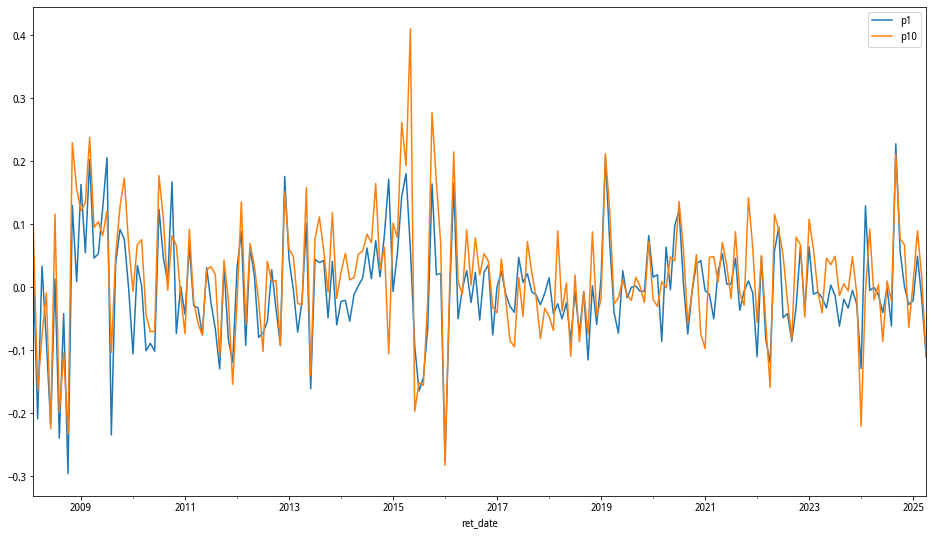

In [78]:
pd.DataFrame(portfolios_crs_mean)[['p1','p10']].plot()

## Double sort

In [79]:
ret_df.rename(columns={'illiq_1m':'illiq'},inplace=True)

In [80]:
from myutils.factor_func import double_sort, factor, daily_factor

In [81]:
double_sort?

Signature:
double_sort(
    df,
    sort1,
    sort2='size',
    group_date='ym',
    merge_cols=['secID', 'ret_date'],
)
Docstring:
Double sorting. 
Arguments:
    sort1: variable 1 for sorting into 3 groups
    sort2: default is "size", sorting into 2 groups
    group_date: the dates upon which the factor exposures are sorted
    merge_cols: the columns
returns:
    portfolios containing 2*3 groups
File:      /srv/data/notes_py3/myutils/factor_func.py
Type:      function


In [82]:
portfolios = double_sort(ret_df, sort1='illiq')

In [83]:
portfolios

{'illiq1_size1':              secID ret_date       ym       ret     exret       size  \
 0      000996.XSHE  2008-02  2008-01  0.100068  0.097122  21.215585   
 1      002032.XSHE  2008-02  2008-01  0.000000 -0.002946  20.937291   
 2      002194.XSHE  2008-02  2008-01  0.001870 -0.001077  21.557135   
 3      600145.XSHG  2008-02  2008-01  0.011704  0.008758  21.248981   
 4      600199.XSHG  2008-02  2008-01  0.011339  0.008393  21.294929   
 5      600247.XSHG  2008-02  2008-01  0.045579  0.042633  21.498881   
 6      600257.XSHG  2008-02  2008-01  0.129336  0.126390  21.382640   
 7      600285.XSHG  2008-02  2008-01  0.034507  0.031561  21.550433   
 ...            ...      ...      ...       ...       ...        ...   
 17894  601061.XSHG  2025-04  2025-03 -0.113163 -0.114672  22.082694   
 17895  603072.XSHG  2025-04  2025-03  0.237932  0.236423  21.759656   
 17896  603194.XSHG  2025-04  2025-03 -0.127960 -0.129469  21.350834   
 17897  603626.XSHG  2025-04  2025-03 -0.125133 

In [84]:
mean_portfolios_ret = dict()
for pf in portfolios.keys():
    mean_portfolios_ret[pf] = portfolios[pf].groupby('ret_date')['exret'].mean()
#     print(mean_portfolios_ret[pf].shape) # print 看一下会不会存在某个月份上没有illiq和size分组没有任何交叉

# Fast merge by stacking
mean_portfolios_ret_df = pd.DataFrame(np.vstack([pf for pf in mean_portfolios_ret.values()])).T
mean_portfolios_ret_df.columns = mean_portfolios_ret.keys()
mean_portfolios_ret_df.index = mean_portfolios_ret['illiq1_size1'].index

# Newey-West adjustment
mean_values = {}
t_values = {}
for k in mean_portfolios_ret.keys():
    y = mean_portfolios_ret[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=4)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

illiq1_size1  illiq1_size2  illiq2_size1  illiq2_size2  \
ret_mean     -0.012044     -0.000619      0.007086      0.005395   
t_values     -1.805483     -0.101503      1.066069      0.874915   

          illiq3_size1  illiq3_size2  
ret_mean      0.016955      0.006462  
t_values      2.439657      1.028930

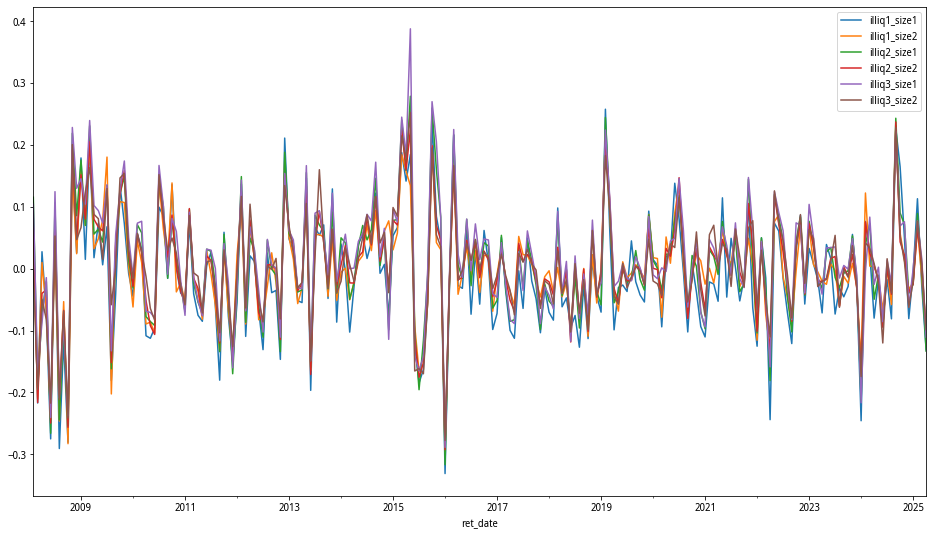

In [85]:
mean_portfolios_ret_df.plot()

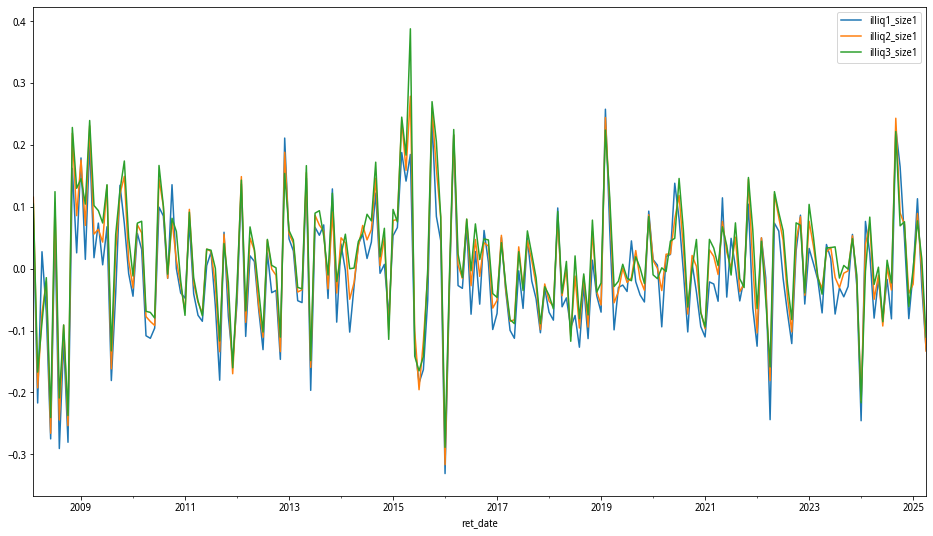

In [86]:
# Within mktcap1, any difference in illiq groups?
pfs = mean_portfolios_ret_df.columns
cols = list(pfs[pfs.str[-5:] == 'size1'])
mean_portfolios_ret_df[cols].plot()

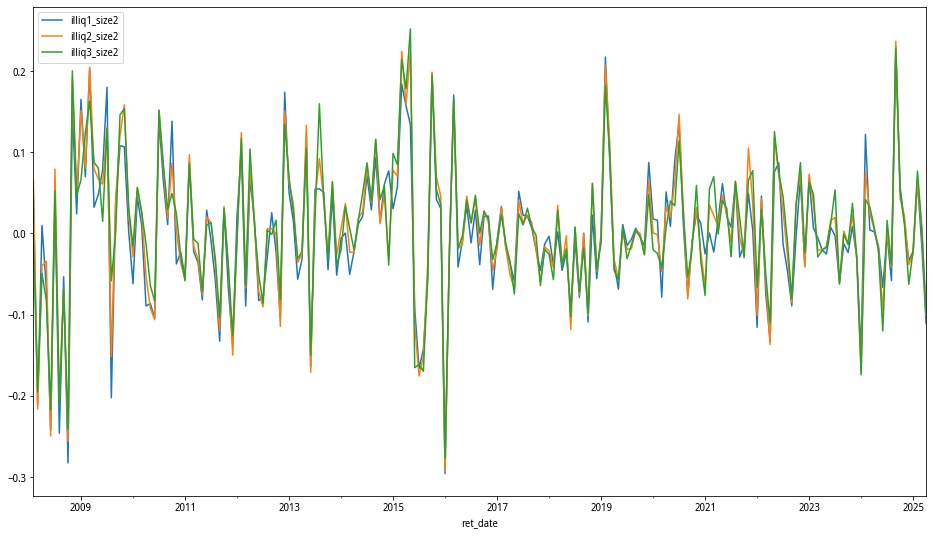

In [87]:
# Within mktcap1, any difference in illiq groups?
pfs = mean_portfolios_ret_df.columns
cols = list(pfs[pfs.str[-5:] == 'size2'])
mean_portfolios_ret_df[cols].plot()

## FM regression

In [88]:
def fm_reg(df,cols):
    df_  = df.dropna()
    if df_.shape[0] < 15:
        return [None]*(len(cols)+1)
    reg = LinearRegression(fit_intercept=True).fit(y=df_.loc[:,'exret'], X=df_.loc[:,cols])
    return np.insert(reg.coef_, 0, reg.intercept_)

In [89]:
cols = ['illiq']
temp = ret_df.groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept     illiq
ret_mean   0.006690  8.853195
t_values   1.180632  2.507906

In [90]:
cols = ['beta','size','bm','mom','rev','illiq']
temp = ret_df.groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept      beta      size        bm       mom       rev  \
ret_mean   0.048082  0.003811 -0.002198  0.005445 -0.000347 -0.047454   
t_values   1.487941  0.979465 -1.705034  1.393540 -0.133445 -6.356458   

              illiq  
ret_mean  12.934119  
t_values   6.666155

# Illiquidity factor

### Long-short factor

In [91]:
illiq_df = factor(ret_df, sort1='illiq', long_only=False)

In [92]:
illiq_df

ret_date
2008-02    0.002133
2008-03    0.021899
2008-04   -0.110798
2008-05    0.020326
2008-06    0.030398
2008-07    0.045830
2008-08    0.017736
2008-09    0.020835
             ...   
2024-09    0.014053
2024-10   -0.019531
2024-11    0.002986
2024-12   -0.022430
2025-01    0.000808
2025-02    0.005724
2025-03    0.022956
2025-04    0.008185
Freq: M, Name: illiq, Length: 207, dtype: float64

In [93]:
factors_df = pd.read_pickle('./output_data/factors/ff3_rev.pkl')

In [94]:
factors_df.index = factors_df.index.to_period('M')

In [95]:
factors_df = pd.merge(factors_df,illiq_df,on='ret_date')

In [96]:
factors_df

mktret  exmktret       SMB       HML       rev     illiq
ret_date                                                            
2009-02   0.058710  0.057622  0.032486  0.028171  0.025780  0.078487
2009-03   0.178938  0.177897  0.054198 -0.006830  0.021235  0.008044
2009-04   0.048803  0.047790  0.024219  0.019751 -0.007459  0.062783
2009-05   0.054285  0.053275  0.030746  0.004025  0.023236  0.026718
2009-06   0.126314  0.125271 -0.071018  0.031210 -0.028539 -0.031355
2009-07   0.170935  0.169708 -0.042418  0.044758  0.003908 -0.002415
2009-08  -0.226937 -0.228372  0.072711 -0.015154  0.043872  0.113976
2009-09   0.056478  0.055019 -0.013508 -0.000016  0.029973  0.022742
...            ...       ...       ...       ...       ...       ...
2024-07  -0.007093 -0.009161  0.008359  0.021592  0.024135  0.019544
2024-08  -0.038931 -0.040999  0.004141  0.003535 -0.003985  0.024411
2024-09   0.216653  0.214585  0.040022 -0.039292  0.051884  0.014053
2024-10  -0.016745 -0.018813  0.098447 -0.053106 -0.048047 -0.019531
2024-11   0.002654  0.000586  0.068044  0.012286  0.056090  0.002986
2024-12  -0.002120 -0.004188 -0.048381  0.037536  0.030380 -0.022430
2025-01  -0.028387 -0.030455  0.011339  0.000906 -0.003487  0.000808
2025-02   0.026599  0.024531  0.056755 -0.039821  0.016696  0.005724

[193 rows x 6 columns]

In [97]:
rf_df = ret_df[['ret_date','rf']].drop_duplicates().sort_values('ret_date').dropna()

In [98]:
factors_df = pd.merge(rf_df,factors_df,on='ret_date').set_index('ret_date')

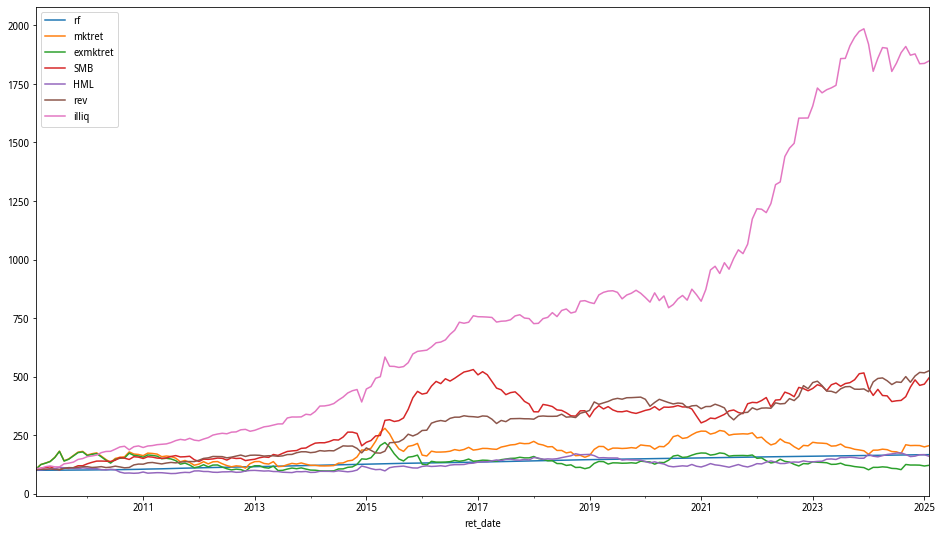

In [99]:
((factors_df+1).cumprod()*100).plot()

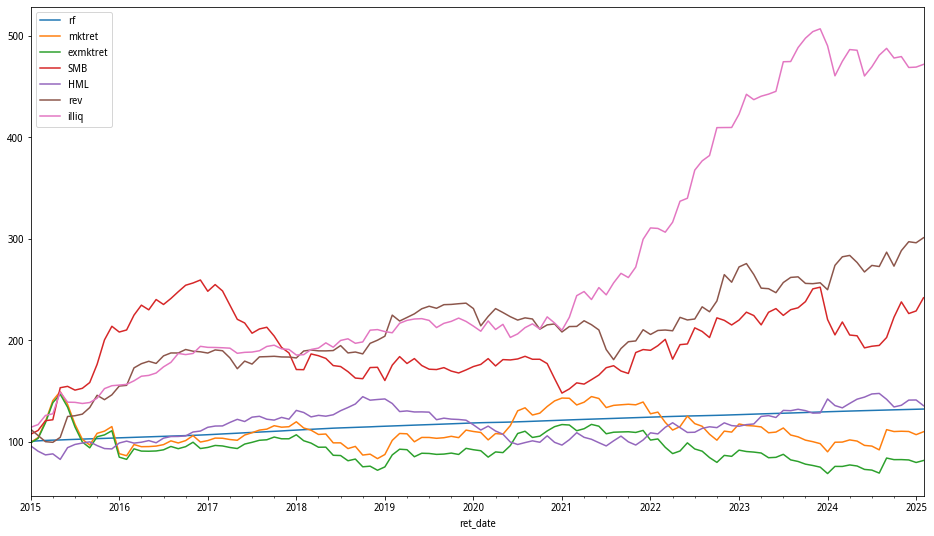

In [100]:
((factors_df['2015':]+1).cumprod()*100).plot()

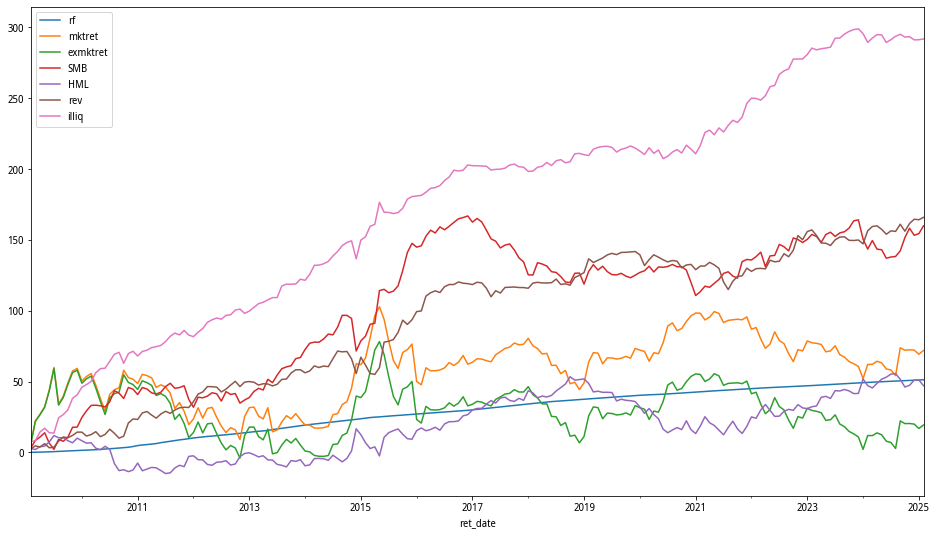

In [101]:
(np.log(1 + factors_df).cumsum()*100).plot()

### Long-only factor

In [102]:
illiq_long_df = factor(ret_df, sort1='illiq')

In [103]:
illiq_long_df

ret_date
2008-02    0.054128
2008-03   -0.180738
2008-04   -0.065558
2008-05   -0.061992
2008-06   -0.217714
2008-07    0.084191
2008-08   -0.206983
2008-09   -0.065913
             ...   
2024-09    0.227407
2024-10    0.058582
2024-11    0.032086
2024-12   -0.059452
2025-01   -0.012925
2025-02    0.075730
2025-03    0.010001
2025-04   -0.100073
Freq: M, Name: illiq, Length: 207, dtype: float64

In [104]:
factors_long_df = pd.read_pickle('./output_data/factors/ff3_rev_long_only.pkl')

In [105]:
factors_long_df.index = factors_long_df.index.to_period('M')

In [106]:
factors_long_df = pd.merge(factors_long_df,illiq_long_df,on='ret_date')

In [107]:
factors_long_df = pd.merge(rf_df,factors_long_df,on='ret_date').set_index('ret_date')

In [108]:
factors_long_df.rename(columns={'illiq':'illiq_long'},inplace=True)

In [109]:
factors_long_df

rf    mktret  exmktret  small_only  high_only  rev_long  \
ret_date                                                                  
2009-02   0.000862  0.058710  0.057622    0.085430   0.084536  0.073752   
2009-03   0.000857  0.178938  0.177897    0.229977   0.192277  0.222602   
2009-04   0.000855  0.048803  0.047790    0.069577   0.062876  0.055581   
2009-05   0.000856  0.054285  0.053275    0.080352   0.064899  0.076523   
2009-06   0.001084  0.126314  0.125271    0.051901   0.097641  0.069063   
2009-07   0.001461  0.170935  0.169708    0.138242   0.188059  0.154281   
2009-08   0.001339 -0.226937 -0.228372   -0.149964  -0.194644 -0.157652   
2009-09   0.001453  0.056478  0.055019    0.038860   0.047223  0.057072   
...            ...       ...       ...         ...        ...       ...   
2024-07   0.001529 -0.007093 -0.009161    0.007591   0.019830  0.013166   
2024-08   0.001518 -0.038931 -0.040999   -0.031232  -0.030772 -0.038172   
2024-09   0.001517  0.216653  0.214585    0.234804   0.194438  0.250951   
2024-10   0.001517 -0.016745 -0.018813    0.089019   0.012109  0.020915   
2024-11   0.001477  0.002654  0.000586    0.072314   0.046916  0.058723   
2024-12   0.001401 -0.002120 -0.004188   -0.052170  -0.007315 -0.028781   
2025-01   0.001422 -0.028387 -0.030455   -0.017141  -0.024264 -0.027236   
2025-02   0.001557  0.026599  0.024531    0.082804   0.034944  0.071393   

          illiq_long  
ret_date              
2009-02     0.115851  
2009-03     0.200210  
2009-04     0.093751  
2009-05     0.088026  
2009-06     0.040224  
2009-07     0.122264  
2009-08    -0.094146  
2009-09     0.030009  
...              ...  
2024-07     0.015501  
2024-08    -0.029232  
2024-09     0.227407  
2024-10     0.058582  
2024-11     0.032086  
2024-12    -0.059452  
2025-01    -0.012925  
2025-02     0.075730  

[193 rows x 7 columns]

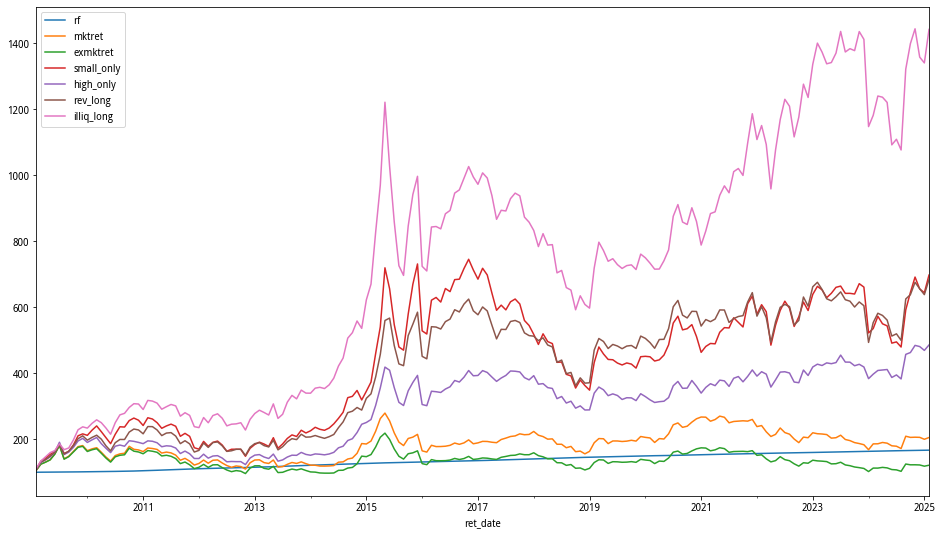

In [110]:
((factors_long_df+1).cumprod()*100).plot()

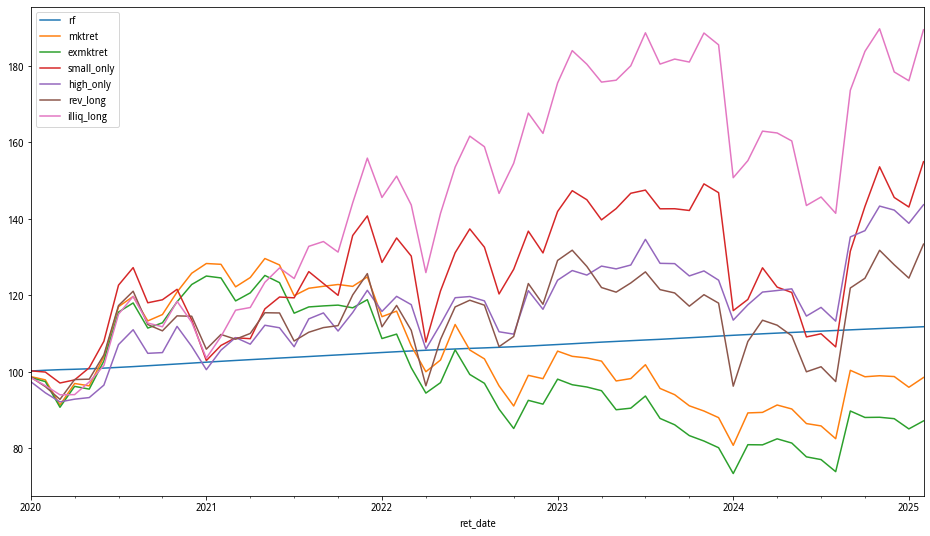

In [111]:
((1 + factors_long_df['2020':]).cumprod()*100).plot()

# Volatility

## Raw volatility

In [112]:
stk_df

secID  tradeDate  preClosePrice  closePrice  negMarketValue  \
0         000001.XSHE 2008-01-02       1221.497    1201.877    6.672404e+10   
1         000001.XSHE 2008-01-03       1201.877    1181.940    6.561725e+10   
2         000001.XSHE 2008-01-04       1181.940    1214.218    6.740920e+10   
3         000001.XSHE 2008-01-07       1214.218    1239.534    6.881466e+10   
4         000001.XSHE 2008-01-08       1239.534    1278.141    7.095798e+10   
5         000001.XSHE 2008-01-09       1278.141    1300.926    7.222289e+10   
6         000001.XSHE 2008-01-10       1300.926    1327.507    7.369862e+10   
7         000001.XSHE 2008-01-11       1327.507    1394.911    7.744065e+10   
...               ...        ...            ...         ...             ...   
13182725  689009.XSHG 2025-03-26         62.447      62.437    3.408568e+10   
13182726  689009.XSHG 2025-03-27         62.437      65.760    3.589992e+10   
13182727  689009.XSHG 2025-03-28         65.760      65.609    3.581745e+10   
13182728  689009.XSHG 2025-03-31         65.609      65.659    3.584494e+10   
13182729  689009.XSHG 2025-04-01         65.659      64.411    3.516323e+10   
13182730  689009.XSHG 2025-04-02         64.411      64.149    3.502029e+10   
13182731  689009.XSHG 2025-04-03         64.149      63.444    3.463545e+10   
13182732  689009.XSHG 2025-04-07         63.444      53.665    2.929719e+10   

          turnoverValue  turnoverRate  ret_daily   illiq_daily       ym  \
0          7.634657e+08        0.0114  -0.016062  2.103861e-11  2008-01   
1          1.023423e+09        0.0157  -0.016588  1.620857e-11  2008-01   
2          7.621612e+08        0.0113   0.027309  3.583145e-11  2008-01   
3          1.236910e+09        0.0179   0.020850  1.685622e-11  2008-01   
4          2.029248e+09        0.0285   0.031146  1.534873e-11  2008-01   
5          7.863130e+08        0.0110   0.017827  2.267122e-11  2008-01   
6          1.016738e+09        0.0139   0.020432  2.009601e-11  2008-01   
7          1.555168e+09        0.0204   0.050775  3.264912e-11  2008-01   
...                 ...           ...        ...           ...      ...   
13182725   2.834881e+08        0.0083  -0.000160  5.648766e-13  2025-03   
13182726   6.975345e+08        0.0197   0.053222  7.629967e-11  2025-03   
13182727   3.724902e+08        0.0104  -0.002296  6.164534e-12  2025-03   
13182728   5.167717e+08        0.0144   0.000762  1.474714e-12  2025-03   
13182729   4.671283e+08        0.0133  -0.019007  4.068967e-11  2025-04   
13182730   2.618055e+08        0.0075  -0.004068  1.553683e-11  2025-04   
13182731   1.100406e+09        0.0334  -0.010990  9.987255e-12  2025-04   
13182732   1.006334e+09        0.0336  -0.154136  1.531658e-10  2025-04   

            illiq_240d  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
5                  NaN  
6                  NaN  
7                  NaN  
...                ...  
13182725  5.547385e-11  
13182726  5.535562e-11  
13182727  5.536953e-11  
13182728  5.456669e-11  
13182729  5.404499e-11  
13182730  5.322541e-11  
13182731  5.226180e-11  
13182732  5.228357e-11  

[13182733 rows x 11 columns]

In [113]:
vol_df = stk_df.groupby(['secID','ym'])['ret_daily'].std()

In [114]:
vol_df

secID        ym     
000001.XSHE  2008-01    0.037722
             2008-02    0.041448
             2008-03    0.045109
             2008-04    0.046323
             2008-05    0.036031
             2008-06    0.041642
             2008-07    0.033244
             2008-08    0.028676
                          ...   
689009.XSHG  2024-09    0.037444
             2024-10    0.057663
             2024-11    0.028503
             2024-12    0.019448
             2025-01    0.027008
             2025-02    0.043253
             2025-03    0.024841
             2025-04    0.071651
Name: ret_daily, Length: 657921, dtype: float64

In [115]:
vol_df = vol_df.to_frame()

In [116]:
vol_df.columns = ['vol']
vol_df.reset_index(inplace=True)

MIN_NOBS = 15
idx = stk_df.groupby(['secID','ym'],as_index=False)['tradeDate'].count()['tradeDate'] < MIN_NOBS

vol_df.loc[idx, 'vol'] = np.nan

In [117]:
vol_df

secID       ym       vol
0       000001.XSHE  2008-01  0.037722
1       000001.XSHE  2008-02  0.041448
2       000001.XSHE  2008-03  0.045109
3       000001.XSHE  2008-04  0.046323
4       000001.XSHE  2008-05  0.036031
5       000001.XSHE  2008-06  0.041642
6       000001.XSHE  2008-07  0.033244
7       000001.XSHE  2008-08  0.028676
...             ...      ...       ...
657913  689009.XSHG  2024-09  0.037444
657914  689009.XSHG  2024-10  0.057663
657915  689009.XSHG  2024-11  0.028503
657916  689009.XSHG  2024-12  0.019448
657917  689009.XSHG  2025-01  0.027008
657918  689009.XSHG  2025-02  0.043253
657919  689009.XSHG  2025-03  0.024841
657920  689009.XSHG  2025-04       NaN

[657921 rows x 3 columns]

下部分需要用到日度因子收益率，先运行 5-factors.ipynb

## Idiosyncratic volatility

Idiosyncratic volatility 指的是被已有的因子收益率回归之后，剩下的残差的波动率。传统金融理论认为残差部分属于可分散的风险，不应该被定价。即使认为因子模型还不够好，残差部分有剩余未被解释的系统性风险的部分，这部分的风险溢价(factor risk premium)也应该是正的。然而，美国市场的数据发现，波动率越低，未来的收益越高。这是一个很有意思的异象。

最广为人知的文献是 Ang, Hodrick, Xing, and Zhang (2006)。

- Bali and Cakici (2008): 数据处理的细节对结果影响很大，包括数据频率、portfolio加权的方式、分位点的计算等等
- Huang et al. (2010 RFS): 这个异象和 reversal 有关
- 其他部分文献：Han and Lesmond (2011), Bali, Cakici, and Whitelaw (2011), Baker, Bradley, and Wurgler (2011), Baker and Wurgler (2014)

我们每个月用因子模型计算一下ivol，用来排序。

一般的解释包括：
- 行为金融：投资者喜欢追逐“彩票”性质的股票
- 卖空限制。由于高波动率股票更难卖空，需要时间调整，导致未来收益率降低
- idio-vol 是对不确定性的衡量

我们最近的研究有一个更简单的解释

$$\text{Pr}_t\left(r_{t+1}>0\right)=1-\text{Pr}_t\left(r_{t+1} \leq 0\right)=1-\operatorname{Pr}\left(\frac{r_{t+1}-\mu}{\sigma_{t+1 \mid t}} \leq \frac{-\mu}{\sigma_{t+1 \mid t}}\right)=\Phi\left(\frac{\mu}{\sigma_{t+1 \mid t}}\right)$$

#### Daily factors

In [118]:
pd.read_pickle('./output_data/factors/factors_daily.pkl')

rf    mktret  exmktret      size        bm       mom  \
tradeDate                                                                
2008-02-01  0.000055 -0.017938 -0.017993 -0.030973 -0.001618       NaN   
2008-02-04  0.000055  0.082467  0.082412 -0.000857  0.006272       NaN   
2008-02-05  0.000062 -0.003663 -0.003725  0.007516  0.004295       NaN   
2008-02-13  0.000061 -0.017980 -0.018041  0.016310  0.003438       NaN   
2008-02-14  0.000060  0.014807  0.014747  0.006229  0.004089       NaN   
2008-02-15  0.000060 -0.011791 -0.011851  0.008785  0.002543       NaN   
2008-02-18  0.000060  0.022921  0.022861  0.009933  0.000150       NaN   
2008-02-19  0.000060  0.021354  0.021294 -0.004680 -0.001609       NaN   
...              ...       ...       ...       ...       ...       ...   
2025-03-26  0.000049 -0.002362 -0.002411  0.013827 -0.000558  0.000104   
2025-03-27  0.000048  0.002859  0.002811 -0.008142 -0.003605  0.002493   
2025-03-28  0.000047 -0.005064 -0.005111 -0.009686  0.000280 -0.000645   
2025-03-31  0.000048 -0.007829 -0.007877 -0.005659 -0.001523  0.008518   
2025-04-01  0.000050  0.001633  0.001583  0.012090  0.005204 -0.013045   
2025-04-02  0.000048 -0.000349 -0.000397  0.001902  0.001636  0.005175   
2025-04-03  0.000044 -0.006728 -0.006772  0.002388  0.013390 -0.010326   
2025-04-07  0.000049 -0.077013 -0.077062 -0.046436  0.025557 -0.014863   

                 rev  
tradeDate             
2008-02-01       NaN  
2008-02-04       NaN  
2008-02-05       NaN  
2008-02-13       NaN  
2008-02-14       NaN  
2008-02-15       NaN  
2008-02-18       NaN  
2008-02-19       NaN  
...              ...  
2025-03-26 -0.002945  
2025-03-27  0.002178  
2025-03-28  0.001381  
2025-03-31 -0.001683  
2025-04-01 -0.003315  
2025-04-02  0.001210  
2025-04-03 -0.003256  
2025-04-07 -0.020701  

[4172 rows x 7 columns]

In [119]:
shibor1d = DataAPI.MktIborGet(secID="Shibor1D.IRCN",beginDate=START,endDate=END,field=['tradeDate','rate'],pandas="1")
shibor1d['tradeDate'] = pd.to_datetime(shibor1d['tradeDate'])
shibor1d['rate'] = shibor1d['rate'] * 0.01 / 365
shibor1d.rename(columns={'rate':'rf'},inplace=True)

In [120]:
factors_daily = pd.read_pickle('./output_data/factors/factors_daily.pkl')

In [121]:
illiq_daily = daily_factor(ret_df, stock_df=stk_df,sort1='illiq',long_only=False)

In [122]:
illiq_daily

tradeDate
2008-02-01    0.002494
2008-02-04   -0.012564
2008-02-05   -0.001844
2008-02-13    0.009927
2008-02-14   -0.006956
2008-02-15   -0.001245
2008-02-18   -0.001331
2008-02-19    0.000626
                ...   
2025-03-26    0.008892
2025-03-27   -0.001341
2025-03-28    0.001216
2025-03-31   -0.002188
2025-04-01    0.011491
2025-04-02    0.001683
2025-04-03    0.003733
2025-04-07   -0.006939
Name: illiq, Length: 4172, dtype: float64

In [123]:
illiq_daily.name = 'illiq'

In [124]:
factors_daily = pd.merge(factors_daily, illiq_daily, on='tradeDate')

In [125]:
factors_daily

rf    mktret  exmktret      size        bm       mom  \
tradeDate                                                                
2008-02-01  0.000055 -0.017938 -0.017993 -0.030973 -0.001618       NaN   
2008-02-04  0.000055  0.082467  0.082412 -0.000857  0.006272       NaN   
2008-02-05  0.000062 -0.003663 -0.003725  0.007516  0.004295       NaN   
2008-02-13  0.000061 -0.017980 -0.018041  0.016310  0.003438       NaN   
2008-02-14  0.000060  0.014807  0.014747  0.006229  0.004089       NaN   
2008-02-15  0.000060 -0.011791 -0.011851  0.008785  0.002543       NaN   
2008-02-18  0.000060  0.022921  0.022861  0.009933  0.000150       NaN   
2008-02-19  0.000060  0.021354  0.021294 -0.004680 -0.001609       NaN   
...              ...       ...       ...       ...       ...       ...   
2025-03-26  0.000049 -0.002362 -0.002411  0.013827 -0.000558  0.000104   
2025-03-27  0.000048  0.002859  0.002811 -0.008142 -0.003605  0.002493   
2025-03-28  0.000047 -0.005064 -0.005111 -0.009686  0.000280 -0.000645   
2025-03-31  0.000048 -0.007829 -0.007877 -0.005659 -0.001523  0.008518   
2025-04-01  0.000050  0.001633  0.001583  0.012090  0.005204 -0.013045   
2025-04-02  0.000048 -0.000349 -0.000397  0.001902  0.001636  0.005175   
2025-04-03  0.000044 -0.006728 -0.006772  0.002388  0.013390 -0.010326   
2025-04-07  0.000049 -0.077013 -0.077062 -0.046436  0.025557 -0.014863   

                 rev     illiq  
tradeDate                       
2008-02-01       NaN  0.002494  
2008-02-04       NaN -0.012564  
2008-02-05       NaN -0.001844  
2008-02-13       NaN  0.009927  
2008-02-14       NaN -0.006956  
2008-02-15       NaN -0.001245  
2008-02-18       NaN -0.001331  
2008-02-19       NaN  0.000626  
...              ...       ...  
2025-03-26 -0.002945  0.008892  
2025-03-27  0.002178 -0.001341  
2025-03-28  0.001381  0.001216  
2025-03-31 -0.001683 -0.002188  
2025-04-01 -0.003315  0.011491  
2025-04-02  0.001210  0.001683  
2025-04-03 -0.003256  0.003733  
2025-04-07 -0.020701 -0.006939  

[4172 rows x 8 columns]

#### 计算月度的 idiosyncratic volatility

In [126]:
def idiovol_np(df, factor_cols, len_periods='1m', min_nobs=15):
    """
    df: year_month is set as index
    """
    year_months = df.index.unique()
    n = len(year_months)
    idiovol = np.full(shape=n, fill_value=np.nan)
    start_notnan_month = int(len_periods[:-1])-1
    for i in range(start_notnan_month,n):
        df_ = df.loc[str(year_months[i]-int(len_periods[:-1])+1) : str(year_months[i]),['exret']+factor_cols].dropna().to_numpy()
        if len(df_) < min_nobs:
            continue
        else:
            y_ = df_[:,0] # 
            X_ = df_[:,1:]
            reg = LinearRegression().fit(y=y_, X=X_)
            res = y_ - reg.predict(X_)
            idiovol[i] = np.std(res)
    idiovol_df = pd.DataFrame({'ym': year_months, f'idiovol{len_periods}': idiovol})
    return idiovol_df

In [127]:
def idiovol(df,factor_cols,min_nobs=15):
    df = df.dropna()
    y = df.loc[:,'exret']
    X = df.loc[:,factor_cols]
    nobs = len(X)
    if nobs < min_nobs:
        idiovol = np.nan
    else:
        reg = LinearRegression().fit(y=y,X=X)
        res = y - reg.predict(X)
        idiovol = np.std(res)
    return idiovol

In [128]:
reg_df = pd.merge(stk_df[['secID','tradeDate','ret_daily']],factors_daily,
                  on=['tradeDate'])

In [129]:
reg_df

secID  tradeDate  ret_daily        rf    mktret  exmktret  \
0         000001.XSHE 2008-02-01   0.037537  0.000055 -0.017938 -0.017993   
1         000002.XSHE 2008-02-01   0.036468  0.000055 -0.017938 -0.017993   
2         000006.XSHE 2008-02-01  -0.016540  0.000055 -0.017938 -0.017993   
3         000012.XSHE 2008-02-01  -0.012061  0.000055 -0.017938 -0.017993   
4         000014.XSHE 2008-02-01  -0.076919  0.000055 -0.017938 -0.017993   
5         000016.XSHE 2008-02-01  -0.047610  0.000055 -0.017938 -0.017993   
6         000019.XSHE 2008-02-01  -0.032467  0.000055 -0.017938 -0.017993   
7         000021.XSHE 2008-02-01  -0.075560  0.000055 -0.017938 -0.017993   
...               ...        ...        ...       ...       ...       ...   
13153261  688789.XSHG 2025-04-07  -0.090984  0.000049 -0.077013 -0.077062   
13153262  688793.XSHG 2025-04-07  -0.200130  0.000049 -0.077013 -0.077062   
13153263  688798.XSHG 2025-04-07  -0.154646  0.000049 -0.077013 -0.077062   
13153264  688799.XSHG 2025-04-07  -0.163956  0.000049 -0.077013 -0.077062   
13153265  688800.XSHG 2025-04-07  -0.199994  0.000049 -0.077013 -0.077062   
13153266  688819.XSHG 2025-04-07  -0.160285  0.000049 -0.077013 -0.077062   
13153267  688981.XSHG 2025-04-07  -0.046430  0.000049 -0.077013 -0.077062   
13153268  689009.XSHG 2025-04-07  -0.154136  0.000049 -0.077013 -0.077062   

              size        bm       mom       rev     illiq  
0        -0.030973 -0.001618       NaN       NaN  0.002494  
1        -0.030973 -0.001618       NaN       NaN  0.002494  
2        -0.030973 -0.001618       NaN       NaN  0.002494  
3        -0.030973 -0.001618       NaN       NaN  0.002494  
4        -0.030973 -0.001618       NaN       NaN  0.002494  
5        -0.030973 -0.001618       NaN       NaN  0.002494  
6        -0.030973 -0.001618       NaN       NaN  0.002494  
7        -0.030973 -0.001618       NaN       NaN  0.002494  
...            ...       ...       ...       ...       ...  
13153261 -0.046436  0.025557 -0.014863 -0.020701 -0.006939  
13153262 -0.046436  0.025557 -0.014863 -0.020701 -0.006939  
13153263 -0.046436  0.025557 -0.014863 -0.020701 -0.006939  
13153264 -0.046436  0.025557 -0.014863 -0.020701 -0.006939  
13153265 -0.046436  0.025557 -0.014863 -0.020701 -0.006939  
13153266 -0.046436  0.025557 -0.014863 -0.020701 -0.006939  
13153267 -0.046436  0.025557 -0.014863 -0.020701 -0.006939  
13153268 -0.046436  0.025557 -0.014863 -0.020701 -0.006939  

[13153269 rows x 11 columns]

In [130]:
reg_df.sort_values(['secID','tradeDate'],inplace=True)

In [131]:
reg_df

secID  tradeDate  ret_daily        rf    mktret  exmktret  \
0         000001.XSHE 2008-02-01   0.037537  0.000055 -0.017938 -0.017993   
1351      000001.XSHE 2008-02-04   0.097830  0.000055  0.082467  0.082412   
2702      000001.XSHE 2008-02-05  -0.016610  0.000062 -0.003663 -0.003725   
4053      000001.XSHE 2008-02-13  -0.024665  0.000061 -0.017980 -0.018041   
5404      000001.XSHE 2008-02-14   0.016767  0.000060  0.014807  0.014747   
6755      000001.XSHE 2008-02-15  -0.025142  0.000060 -0.011791 -0.011851   
8106      000001.XSHE 2008-02-18   0.011925  0.000060  0.022921  0.022861   
9459      000001.XSHE 2008-02-19   0.021649  0.000060  0.021354  0.021294   
...               ...        ...        ...       ...       ...       ...   
13118241  689009.XSHG 2025-03-26  -0.000160  0.000049 -0.002362 -0.002411   
13123245  689009.XSHG 2025-03-27   0.053222  0.000048  0.002859  0.002811   
13128249  689009.XSHG 2025-03-28  -0.002296  0.000047 -0.005064 -0.005111   
13133253  689009.XSHG 2025-03-31   0.000762  0.000048 -0.007829 -0.007877   
13138256  689009.XSHG 2025-04-01  -0.019007  0.000050  0.001633  0.001583   
13143260  689009.XSHG 2025-04-02  -0.004068  0.000048 -0.000349 -0.000397   
13148264  689009.XSHG 2025-04-03  -0.010990  0.000044 -0.006728 -0.006772   
13153268  689009.XSHG 2025-04-07  -0.154136  0.000049 -0.077013 -0.077062   

              size        bm       mom       rev     illiq  
0        -0.030973 -0.001618       NaN       NaN  0.002494  
1351     -0.000857  0.006272       NaN       NaN -0.012564  
2702      0.007516  0.004295       NaN       NaN -0.001844  
4053      0.016310  0.003438       NaN       NaN  0.009927  
5404      0.006229  0.004089       NaN       NaN -0.006956  
6755      0.008785  0.002543       NaN       NaN -0.001245  
8106      0.009933  0.000150       NaN       NaN -0.001331  
9459     -0.004680 -0.001609       NaN       NaN  0.000626  
...            ...       ...       ...       ...       ...  
13118241  0.013827 -0.000558  0.000104 -0.002945  0.008892  
13123245 -0.008142 -0.003605  0.002493  0.002178 -0.001341  
13128249 -0.009686  0.000280 -0.000645  0.001381  0.001216  
13133253 -0.005659 -0.001523  0.008518 -0.001683 -0.002188  
13138256  0.012090  0.005204 -0.013045 -0.003315  0.011491  
13143260  0.001902  0.001636  0.005175  0.001210  0.001683  
13148264  0.002388  0.013390 -0.010326 -0.003256  0.003733  
13153268 -0.046436  0.025557 -0.014863 -0.020701 -0.006939  

[13153269 rows x 11 columns]

In [132]:
reg_df['exret'] = reg_df['ret_daily'] - reg_df['rf']

In [133]:
reg_df['ym'] = reg_df['tradeDate'].dt.to_period('M')

#### 代码测试

In [134]:
# Testing the time consuming 
ids = reg_df['secID'].unique()
ids_ = np.random.choice(ids, 50)
temp = reg_df[reg_df['secID'].isin(ids_)]

In [135]:
temp.set_index('ym',inplace=True)

In [136]:
temp

secID  tradeDate  ret_daily        rf    mktret  exmktret  \
ym                                                                         
2014-04  000035.XSHE 2014-04-22   0.089121  0.000053  0.001874  0.001821   
2014-04  000035.XSHE 2014-04-23  -0.063620  0.000054 -0.001962 -0.002016   
2014-04  000035.XSHE 2014-04-24  -0.050335  0.000063 -0.004498 -0.004561   
2014-04  000035.XSHE 2014-04-25  -0.035308  0.000063 -0.013440 -0.013503   
2014-04  000035.XSHE 2014-04-28  -0.005766  0.000066 -0.019338 -0.019404   
2014-04  000035.XSHE 2014-04-29   0.000000  0.000071  0.012012  0.011941   
2014-04  000035.XSHE 2014-04-30   0.063960  0.000068  0.002027  0.001959   
2014-05  000035.XSHE 2014-05-05   0.000000  0.000065  0.001570  0.001505   
...              ...        ...        ...       ...       ...       ...   
2025-03  688700.XSHG 2025-03-26  -0.037913  0.000049 -0.002362 -0.002411   
2025-03  688700.XSHG 2025-03-27  -0.016312  0.000048  0.002859  0.002811   
2025-03  688700.XSHG 2025-03-28  -0.020153  0.000047 -0.005064 -0.005111   
2025-03  688700.XSHG 2025-03-31   0.016407  0.000048 -0.007829 -0.007877   
2025-04  688700.XSHG 2025-04-01  -0.008449  0.000050  0.001633  0.001583   
2025-04  688700.XSHG 2025-04-02  -0.044696  0.000048 -0.000349 -0.000397   
2025-04  688700.XSHG 2025-04-03  -0.027585  0.000044 -0.006728 -0.006772   
2025-04  688700.XSHG 2025-04-07  -0.199946  0.000049 -0.077013 -0.077062   

             size        bm       mom       rev     illiq     exret  
ym                                                                   
2014-04 -0.005909  0.011373 -0.014102 -0.009864 -0.002709  0.089068  
2014-04  0.001534  0.004376 -0.007040 -0.002462  0.000362 -0.063674  
2014-04 -0.001255  0.002015 -0.004185 -0.003492  0.003783 -0.050398  
2014-04 -0.004616  0.005154 -0.008028 -0.009657  0.000783 -0.035372  
2014-04 -0.013640  0.012640 -0.015355 -0.014298 -0.000356 -0.005832  
2014-04  0.002559 -0.004293  0.005382  0.004217 -0.001181 -0.000071  
2014-04  0.004411 -0.007135  0.008253  0.002672  0.004186  0.063892  
2014-05  0.007503 -0.010348  0.009967 -0.000198  0.005884 -0.000065  
...           ...       ...       ...       ...       ...       ...  
2025-03  0.013827 -0.000558  0.000104 -0.002945  0.008892 -0.037962  
2025-03 -0.008142 -0.003605  0.002493  0.002178 -0.001341 -0.016360  
2025-03 -0.009686  0.000280 -0.000645  0.001381  0.001216 -0.020201  
2025-03 -0.005659 -0.001523  0.008518 -0.001683 -0.002188  0.016359  
2025-04  0.012090  0.005204 -0.013045 -0.003315  0.011491 -0.008499  
2025-04  0.001902  0.001636  0.005175  0.001210  0.001683 -0.044744  
2025-04  0.002388  0.013390 -0.010326 -0.003256  0.003733 -0.027629  
2025-04 -0.046436  0.025557 -0.014863 -0.020701 -0.006939 -0.199995  

[103207 rows x 12 columns]

In [137]:
%%time
result1 = temp.groupby(['secID','ym']).apply(idiovol, factor_cols=['exmktret','size','bm','mom','rev','illiq'])

CPU times: user 33 s, sys: 144 ms, total: 33.2 s
Wall time: 33.2 s


In [138]:
%%time
result2 = temp.groupby(['secID']).apply(idiovol_np, factor_cols=['exmktret','size','bm','mom','rev','illiq'])

CPU times: user 22.7 s, sys: 400 ms, total: 23.1 s
Wall time: 23.2 s


In [139]:
result1

secID        ym     
000035.XSHE  2014-04         NaN
             2014-05    0.007408
             2014-06    0.011562
             2014-07    0.012087
             2014-08    0.012154
             2014-09    0.013913
             2014-10    0.016192
             2014-11    0.011115
                          ...   
688700.XSHG  2024-09    0.011650
             2024-10    0.043935
             2024-11    0.029986
             2024-12    0.023072
             2025-01    0.034025
             2025-02    0.022132
             2025-03    0.045411
             2025-04         NaN
Length: 5165, dtype: float64

In [140]:
result2

ym  idiovol1m
secID                             
000035.XSHE 0   2014-04        NaN
            1   2014-05   0.007408
            2   2014-06   0.011562
            3   2014-07   0.012087
            4   2014-08   0.012154
            5   2014-09   0.013913
            6   2014-10   0.016192
            7   2014-11   0.011115
...                 ...        ...
688700.XSHG 39  2024-09   0.011650
            40  2024-10   0.043935
            41  2024-11   0.029986
            42  2024-12   0.023072
            43  2025-01   0.034025
            44  2025-02   0.022132
            45  2025-03   0.045411
            46  2025-04        NaN

[5165 rows x 2 columns]

In [141]:
result1 = result1.to_frame().reset_index()
result1.columns = ['secID','ym','r1']

In [142]:
result2 = result2.reset_index().drop('level_1',axis=1)

In [143]:
result = pd.merge(result1, result2, on=['secID','ym'])

In [144]:
result

secID       ym        r1  idiovol1m
0     000035.XSHE  2014-04       NaN        NaN
1     000035.XSHE  2014-05  0.007408   0.007408
2     000035.XSHE  2014-06  0.011562   0.011562
3     000035.XSHE  2014-07  0.012087   0.012087
4     000035.XSHE  2014-08  0.012154   0.012154
5     000035.XSHE  2014-09  0.013913   0.013913
6     000035.XSHE  2014-10  0.016192   0.016192
7     000035.XSHE  2014-11  0.011115   0.011115
...           ...      ...       ...        ...
5157  688700.XSHG  2024-09  0.011650   0.011650
5158  688700.XSHG  2024-10  0.043935   0.043935
5159  688700.XSHG  2024-11  0.029986   0.029986
5160  688700.XSHG  2024-12  0.023072   0.023072
5161  688700.XSHG  2025-01  0.034025   0.034025
5162  688700.XSHG  2025-02  0.022132   0.022132
5163  688700.XSHG  2025-03  0.045411   0.045411
5164  688700.XSHG  2025-04       NaN        NaN

[5165 rows x 4 columns]

In [145]:
(result['r1'] - result['idiovol1m']).sum()

-2.4091994006120534e-16

In [146]:
result['r1'].to_numpy()

array([       nan, 0.00740841, 0.01156173, ..., 0.02213232, 0.04541146,
              nan])

In [147]:
result['idiovol1m'].to_numpy()

array([       nan, 0.00740841, 0.01156173, ..., 0.02213232, 0.04541146,
              nan])

In [148]:
np.array_equal(result['r1'].to_numpy(), result['idiovol1m'].to_numpy())

False

In [149]:
np.allclose(result['r1'].to_numpy(), result['idiovol1m'].to_numpy())

False

In [150]:
result.fillna(0, inplace=True)

In [151]:
np.array_equal(result['r1'].to_numpy(), result['idiovol1m'].to_numpy())

False

In [152]:
np.allclose(result['r1'].to_numpy(), result['idiovol1m'].to_numpy())

True

#### 实际计算

In [153]:
reg_df.set_index('ym',inplace=True)

In [154]:
reg_df

secID  tradeDate  ret_daily        rf    mktret  exmktret  \
ym                                                                         
2008-02  000001.XSHE 2008-02-01   0.037537  0.000055 -0.017938 -0.017993   
2008-02  000001.XSHE 2008-02-04   0.097830  0.000055  0.082467  0.082412   
2008-02  000001.XSHE 2008-02-05  -0.016610  0.000062 -0.003663 -0.003725   
2008-02  000001.XSHE 2008-02-13  -0.024665  0.000061 -0.017980 -0.018041   
2008-02  000001.XSHE 2008-02-14   0.016767  0.000060  0.014807  0.014747   
2008-02  000001.XSHE 2008-02-15  -0.025142  0.000060 -0.011791 -0.011851   
2008-02  000001.XSHE 2008-02-18   0.011925  0.000060  0.022921  0.022861   
2008-02  000001.XSHE 2008-02-19   0.021649  0.000060  0.021354  0.021294   
...              ...        ...        ...       ...       ...       ...   
2025-03  689009.XSHG 2025-03-26  -0.000160  0.000049 -0.002362 -0.002411   
2025-03  689009.XSHG 2025-03-27   0.053222  0.000048  0.002859  0.002811   
2025-03  689009.XSHG 2025-03-28  -0.002296  0.000047 -0.005064 -0.005111   
2025-03  689009.XSHG 2025-03-31   0.000762  0.000048 -0.007829 -0.007877   
2025-04  689009.XSHG 2025-04-01  -0.019007  0.000050  0.001633  0.001583   
2025-04  689009.XSHG 2025-04-02  -0.004068  0.000048 -0.000349 -0.000397   
2025-04  689009.XSHG 2025-04-03  -0.010990  0.000044 -0.006728 -0.006772   
2025-04  689009.XSHG 2025-04-07  -0.154136  0.000049 -0.077013 -0.077062   

             size        bm       mom       rev     illiq     exret  
ym                                                                   
2008-02 -0.030973 -0.001618       NaN       NaN  0.002494  0.037483  
2008-02 -0.000857  0.006272       NaN       NaN -0.012564  0.097775  
2008-02  0.007516  0.004295       NaN       NaN -0.001844 -0.016672  
2008-02  0.016310  0.003438       NaN       NaN  0.009927 -0.024726  
2008-02  0.006229  0.004089       NaN       NaN -0.006956  0.016707  
2008-02  0.008785  0.002543       NaN       NaN -0.001245 -0.025202  
2008-02  0.009933  0.000150       NaN       NaN -0.001331  0.011865  
2008-02 -0.004680 -0.001609       NaN       NaN  0.000626  0.021589  
...           ...       ...       ...       ...       ...       ...  
2025-03  0.013827 -0.000558  0.000104 -0.002945  0.008892 -0.000209  
2025-03 -0.008142 -0.003605  0.002493  0.002178 -0.001341  0.053174  
2025-03 -0.009686  0.000280 -0.000645  0.001381  0.001216 -0.002344  
2025-03 -0.005659 -0.001523  0.008518 -0.001683 -0.002188  0.000714  
2025-04  0.012090  0.005204 -0.013045 -0.003315  0.011491 -0.019057  
2025-04  0.001902  0.001636  0.005175  0.001210  0.001683 -0.004116  
2025-04  0.002388  0.013390 -0.010326 -0.003256  0.003733 -0.011034  
2025-04 -0.046436  0.025557 -0.014863 -0.020701 -0.006939 -0.154185  

[13153269 rows x 12 columns]

In [145]:
reg_df['secID'].nunique()

5299

In [155]:
# %%time
# ivol = reg_df.groupby(['secID']).apply(idiovol_np, factor_cols=['exmktret','size','bm','mom','rev','illiq'])
# # Takes about 48min to execute

CPU times: user 47min 44s, sys: 51 s, total: 48min 35s
Wall time: 48min 42s


In [158]:
# ivol = ivol.reset_index().drop('level_1',axis=1)

In [159]:
# ivol

secID       ym  idiovol1m
0       000001.XSHE  2008-02        NaN
1       000001.XSHE  2008-03        NaN
2       000001.XSHE  2008-04        NaN
3       000001.XSHE  2008-05        NaN
4       000001.XSHE  2008-06        NaN
5       000001.XSHE  2008-07        NaN
6       000001.XSHE  2008-08        NaN
7       000001.XSHE  2008-09        NaN
...             ...      ...        ...
656566  689009.XSHG  2024-09   0.021285
656567  689009.XSHG  2024-10   0.020563
656568  689009.XSHG  2024-11   0.018614
656569  689009.XSHG  2024-12   0.016439
656570  689009.XSHG  2025-01   0.022593
656571  689009.XSHG  2025-02   0.027439
656572  689009.XSHG  2025-03   0.015302
656573  689009.XSHG  2025-04        NaN

[656574 rows x 3 columns]

In [160]:
# ivol.to_pickle('./data/idiovol1m.pkl')

In [161]:
ivol = pd.read_pickle('./data/idiovol1m.pkl')

In [163]:
vol_df = pd.merge(vol_df,ivol,on=['secID','ym'])

In [164]:
vol_df

secID       ym       vol  idiovol1m
0       000001.XSHE  2008-02  0.041448        NaN
1       000001.XSHE  2008-03  0.045109        NaN
2       000001.XSHE  2008-04  0.046323        NaN
3       000001.XSHE  2008-05  0.036031        NaN
4       000001.XSHE  2008-06  0.041642        NaN
5       000001.XSHE  2008-07  0.033244        NaN
6       000001.XSHE  2008-08  0.028676        NaN
7       000001.XSHE  2008-09  0.053642        NaN
...             ...      ...       ...        ...
656566  689009.XSHG  2024-09  0.037444   0.021285
656567  689009.XSHG  2024-10  0.057663   0.020563
656568  689009.XSHG  2024-11  0.028503   0.018614
656569  689009.XSHG  2024-12  0.019448   0.016439
656570  689009.XSHG  2025-01  0.027008   0.022593
656571  689009.XSHG  2025-02  0.043253   0.027439
656572  689009.XSHG  2025-03  0.024841   0.015302
656573  689009.XSHG  2025-04       NaN        NaN

[656574 rows x 4 columns]

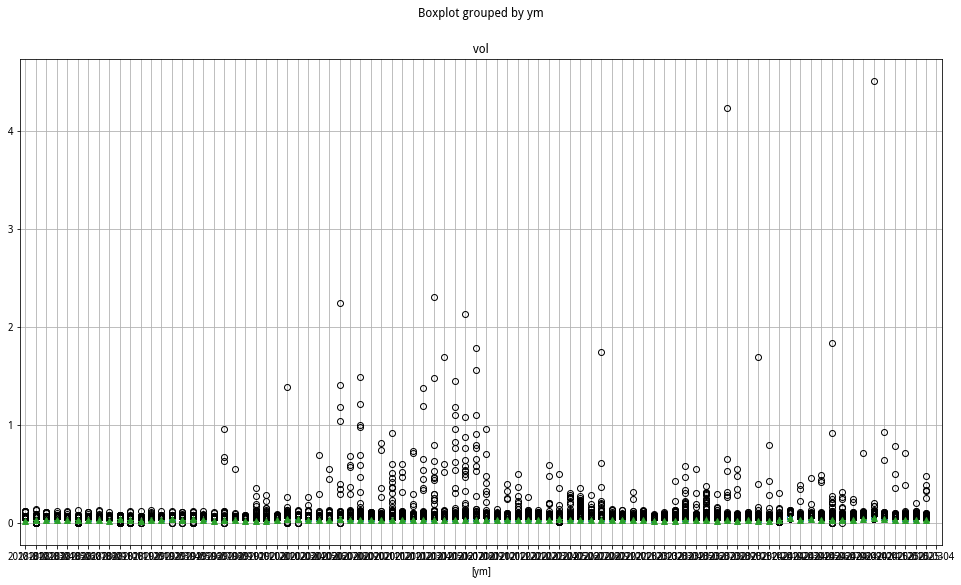

In [165]:
vol_df.loc[vol_df['ym']>='2018',['ym','vol']].boxplot(by='ym',showmeans=True)

In [166]:
vol_df['vol_clip'] = vol_df['vol'].clip(lower=vol_df['vol'].quantile(0.001),
                                        upper=vol_df['vol'].quantile(0.999))
vol_df['ivol_clip'] = vol_df['idiovol1m'].clip(lower=vol_df['idiovol1m'].quantile(0.001),
                                               upper=vol_df['idiovol1m'].quantile(0.999))

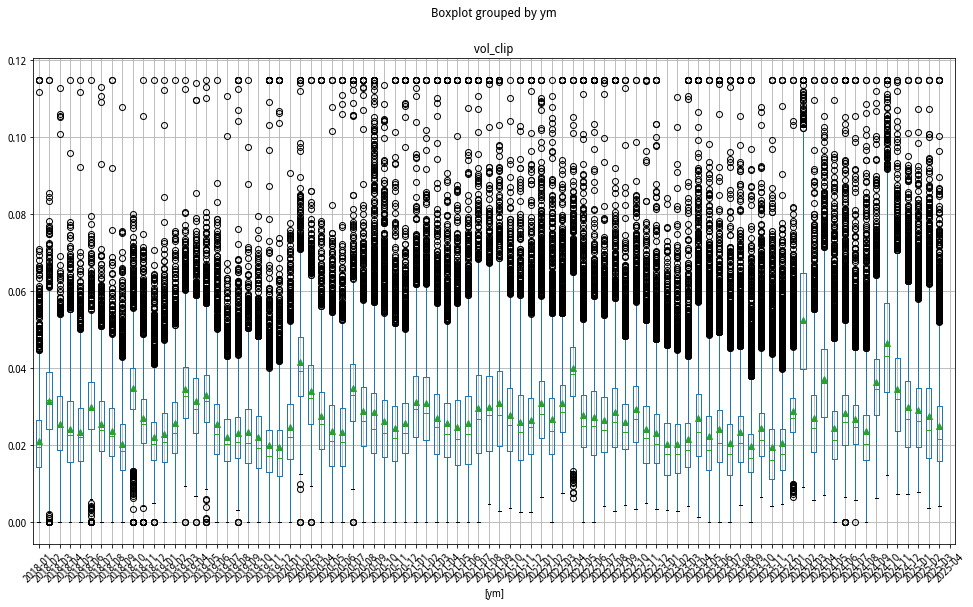

In [167]:
vol_df.loc[vol_df['ym']>='2018',['ym','vol_clip']].boxplot(by='ym',showmeans=True,rot=45)

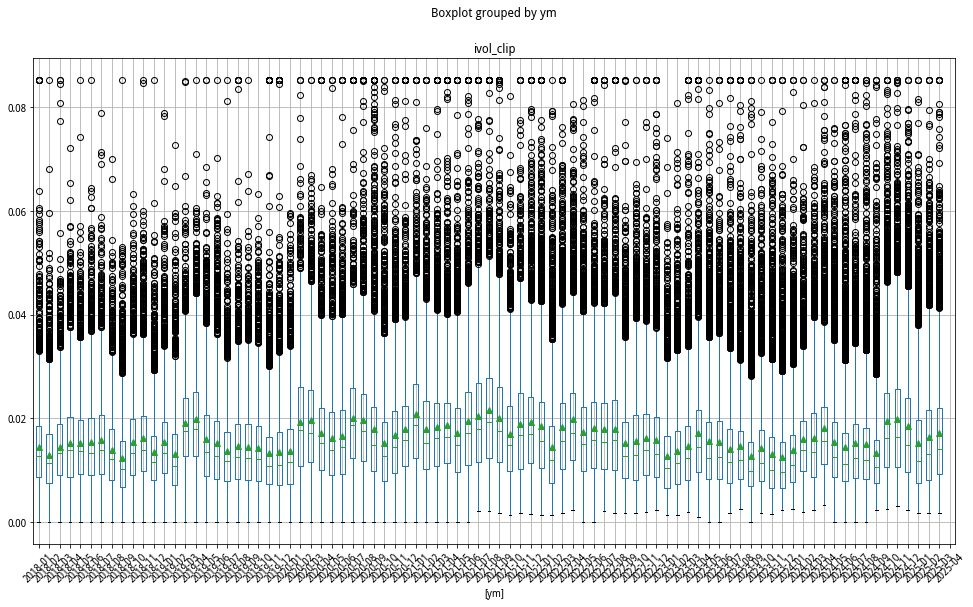

In [168]:
vol_df.loc[vol_df['ym']>='2018',['ym','ivol_clip']].boxplot(by='ym',showmeans=True,rot=45)

In [169]:
vol_df.loc[:,'vol':'ivol_clip'].describe()

vol     idiovol1m       vol_clip     ivol_clip
count  633856.000000  6.177940e+05  633856.000000  6.177940e+05
mean        0.027732  1.600472e-02       0.027514  1.585257e-02
std         0.022032  1.585983e-02       0.014082  9.809617e-03
min         0.000000  3.356741e-08       0.000000  3.604826e-07
25%         0.017849  9.040489e-03       0.017849  9.040489e-03
50%         0.024859  1.363536e-02       0.024859  1.363536e-02
75%         0.034436  2.042889e-02       0.034436  2.042889e-02
max         4.874535  3.685992e+00       0.114698  8.512732e-02

In [170]:
vol_df.rename(columns={'idiovol1m':'ivol'},inplace=True)

## Sorting and Factors

In [171]:
ret_df = pd.merge(ret_df,vol_df,
                  on=['secID','ym'])

In [172]:
ret_df

secID ret_date  tradeDate       ret        rf     exret  \
0       000001.XSHE  2008-03 2008-02-29 -0.149321  0.002746 -0.152068   
1       000001.XSHE  2008-04 2008-03-31  0.050355  0.002862  0.047493   
2       000001.XSHE  2008-05 2008-04-30 -0.148211  0.002953 -0.151164   
3       000001.XSHE  2008-06 2008-05-30 -0.233848  0.003113 -0.236961   
4       000001.XSHE  2008-07 2008-06-30  0.076047  0.002806  0.073241   
5       000001.XSHE  2008-08 2008-07-31 -0.028846  0.002681 -0.031527   
6       000001.XSHE  2008-09 2008-08-29 -0.257922  0.002889 -0.260811   
7       000001.XSHE  2008-10 2008-09-26 -0.271959  0.002509 -0.274468   
...             ...      ...        ...       ...       ...       ...   
652728  689009.XSHG  2024-10 2024-09-30 -0.080923  0.001517 -0.082440   
652729  689009.XSHG  2024-11 2024-10-31  0.004506  0.001477  0.003029   
652730  689009.XSHG  2024-12 2024-11-29  0.067436  0.001401  0.066035   
652731  689009.XSHG  2025-01 2024-12-31  0.080840  0.001422  0.079419   
652732  689009.XSHG  2025-02 2025-01-27  0.113168  0.001557  0.111611   
652733  689009.XSHG  2025-03 2025-02-28  0.140844  0.001607  0.139237   
652734  689009.XSHG  2025-04 2025-03-31 -0.182671  0.001509 -0.184180   
652735  689009.XSHG      NaT 2025-04-07       NaN       NaN       NaN   

             ym        mktcap       size       rev mom_date       mom    beta  \
0       2008-02  5.823860e+10  24.787814 -0.007450  2008-01       NaN  1.0292   
1       2008-03  4.954234e+10  24.626093 -0.152068  2008-02       NaN  1.0238   
2       2008-04  5.203702e+10  24.675221  0.047493  2008-03       NaN  1.0212   
3       2008-05  4.432458e+10  24.514805 -0.151164  2008-04       NaN  1.0697   
4       2008-06  4.140495e+10  24.446666 -0.236961  2008-05       NaN  1.0672   
5       2008-07  4.455369e+10  24.519961  0.073241  2008-06       NaN  1.0966   
6       2008-08  4.326849e+10  24.490690 -0.031527  2008-07       NaN  1.0386   
7       2008-09  3.210865e+10  24.192391 -0.260811  2008-08       NaN  1.1184   
...         ...           ...        ...       ...      ...       ...     ...   
652728  2024-09  2.633272e+10  23.994078  0.076791  2024-08  0.292420  1.0361   
652729  2024-10  2.420206e+10  23.909704 -0.082440  2024-09  0.480329  1.3022   
652730  2024-11  2.431436e+10  23.914333  0.003029  2024-10  0.347795  1.2585   
652731  2024-12  2.610548e+10  23.985411  0.066035  2024-11  0.510890  1.2255   
652732  2025-01  2.822514e+10  24.063479  0.079419  2024-12  1.049486  1.1695   
652733  2025-02  3.141930e+10  24.170688  0.111611  2025-01  0.706337  1.2526   
652734  2025-03  3.584494e+10  24.302468  0.139237  2025-02  0.921636  1.3115   
652735  2025-04  2.929719e+10  24.100757 -0.184180  2025-03  0.764553  1.5641   

              bm     illiq  illiq_12m       vol      ivol  vol_clip  ivol_clip  
0       0.110009  0.000064        NaN  0.041448       NaN  0.041448        NaN  
1       0.201102  0.000043        NaN  0.045109       NaN  0.045109        NaN  
2       0.206701  0.000051        NaN  0.046323       NaN  0.046323        NaN  
3       0.242665  0.000071        NaN  0.036031       NaN  0.036031        NaN  
4       0.304090  0.000084        NaN  0.041642       NaN  0.041642        NaN  
5       0.282598  0.000083        NaN  0.033244       NaN  0.033244        NaN  
6       0.351136  0.000093        NaN  0.028676       NaN  0.028676        NaN  
7       0.473171  0.000175        NaN  0.053642       NaN  0.053642        NaN  
...          ...       ...        ...       ...       ...       ...        ...  
652728  0.162713  0.000041   0.000103  0.037444  0.021285  0.037444   0.021285  
652729  0.190752  0.000056   0.000091  0.057663  0.020563  0.057663   0.020563  
652730  0.189876  0.000047   0.000088  0.028503  0.018614  0.028503   0.018614  
652731  0.177806  0.000028   0.000080  0.019448  0.016439  0.019448   0.016439  
652732  0.164468  0.000045   0.000069  0.027008  0.022593  0.027008   0.022593  
652733  0.147748  0.00003

In [173]:
def single_sort(df, sort):
    q = dict()
    keys = ['q'+str(i) for i in range(1, 10)]
    values = np.arange(0.1, 1.0, 0.1)
    q.update(zip(keys,values))

    quantile_df = pd.DataFrame()
    for key, value in q.items():
        quantile_df[key] = df.groupby(['ym'])[sort].quantile(value)

    df_q = pd.merge(df, quantile_df, on='ym')

    portfolios = dict()
    drop_cols = [col for col in df_q.columns if col[0]=='q']

    portfolios['p1'] = df_q.loc[df_q[sort] <= df_q['q1']].copy().drop(drop_cols, axis=1)
    for i in range(2,10):
        idx = (df_q[f'q{i-1}'] <= df_q[sort]) & (df_q[sort] <= df_q[f'q{i}'])
        portfolios[f'p{i}'] = df_q.loc[idx].copy().drop(drop_cols, axis=1)
    portfolios['p10'] = df_q.loc[df_q[sort] >= df_q['q9']].copy().drop(drop_cols, axis=1)

    portfolios_crs_mean = dict()
    for k in portfolios.keys():
        portfolios_crs_mean[k] = portfolios[k].groupby(['ret_date'])['exret'].mean()

    mean_values = {}
    t_values = {}
    for k in portfolios_crs_mean.keys():
        y = portfolios_crs_mean[k]
        const = np.full(shape=len(y),fill_value=1)
        reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
        mean_values[k] = reg.params[0]
        t_values[k] = reg.tvalues[0]
    # Portfolio 10-1
    y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
    const = np.full(shape=len(y), fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values['p10-p1'] = reg.params[0]
    t_values['p10-p1'] = reg.tvalues[0]

    display(pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
                 columns=mean_values.keys()))

### Raw volatility

In [174]:
single_sort(ret_df, 'vol')

p1        p2        p3        p4        p5        p6        p7  \
mean     0.008327  0.007798  0.008849  0.009544  0.009277  0.009426  0.007479   
t-value  1.275460  1.285889  1.375148  1.469946  1.422021  1.445119  1.104066   

               p8        p9       p10    p10-p1  
mean     0.005668  0.003907 -0.005663 -0.013990  
t-value  0.848551  0.565944 -0.798152 -4.608592

In [175]:
portfolios = double_sort(ret_df, sort1='vol')

mean_portfolios_ret = dict()
for pf in portfolios.keys():
    mean_portfolios_ret[pf] = portfolios[pf].groupby('ret_date')['exret'].mean()
    print(mean_portfolios_ret[pf].shape) # print 看一下会不会存在某个月份上没有vol和size分组没有任何交叉

# Fast merge by stacking
mean_portfolios_ret_df = pd.DataFrame(np.vstack([pf for pf in mean_portfolios_ret.values()])).T
mean_portfolios_ret_df.columns = mean_portfolios_ret.keys()
mean_portfolios_ret_df.index = mean_portfolios_ret['vol1_size1'].index

# Newey-West adjustment
mean_values = {}
t_values = {}
for k in mean_portfolios_ret.keys():
    y = mean_portfolios_ret[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=4)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

(206,)
(206,)
(206,)
(206,)
(206,)
(206,)


vol1_size1  vol1_size2  vol2_size1  vol2_size2  vol3_size1  \
ret_mean    0.014688    0.003289    0.013589    0.003948    0.004717   
t_values    2.122965    0.571224    1.978722    0.612431    0.652032   

          vol3_size2  
ret_mean   -0.002312  
t_values   -0.343865

In [176]:
cols = ['beta','size','bm','mom','rev','illiq','vol']
temp = ret_df.groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept      beta      size        bm       mom       rev  \
ret_mean   0.062485  0.005975 -0.002537  0.003460  0.001959 -0.031513   
t_values   2.082142  1.847316 -2.093286  0.897295  0.793168 -4.009070   

              illiq       vol  
ret_mean  11.608932 -0.376170  
t_values   5.891328 -4.716134

In [177]:
cols = ['beta','size','bm','mom','rev','illiq','vol_clip']
temp = ret_df.groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept      beta      size        bm       mom       rev  \
ret_mean   0.062483  0.005975 -0.002537  0.003460  0.001959 -0.031505   
t_values   2.081775  1.847078 -2.092895  0.897232  0.793178 -4.008007   

              illiq  vol_clip  
ret_mean  11.607860 -0.376142  
t_values   5.890436 -4.715670

### Idiosyncratic volatility

In [178]:
single_sort(ret_df, 'ivol')

p1        p2        p3        p4        p5        p6        p7  \
mean     0.015010  0.013882  0.015124  0.013477  0.012465  0.011752  0.009406   
t-value  2.378219  2.548689  2.643766  2.554250  2.295075  2.172966  1.769398   

               p8        p9       p10    p10-p1  
mean     0.007391  0.003908 -0.004919 -0.019929  
t-value  1.333617  0.665040 -0.814669 -7.201968

In [179]:
portfolios = double_sort(ret_df, sort1='ivol')

mean_portfolios_ret = dict()
for pf in portfolios.keys():
    mean_portfolios_ret[pf] = portfolios[pf].groupby('ret_date')['exret'].mean()
    print(mean_portfolios_ret[pf].shape) # print 看一下会不会存在某个月份上没有vol和size分组没有任何交叉

# Fast merge by stacking
mean_portfolios_ret_df = pd.DataFrame(np.vstack([pf for pf in mean_portfolios_ret.values()])).T
mean_portfolios_ret_df.columns = mean_portfolios_ret.keys()
mean_portfolios_ret_df.index = mean_portfolios_ret['ivol1_size1'].index

# Newey-West adjustment
mean_values = {}
t_values = {}
for k in mean_portfolios_ret.keys():
    y = mean_portfolios_ret[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=4)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

(195,)
(195,)
(195,)
(195,)
(195,)
(195,)


ivol1_size1  ivol1_size2  ivol2_size1  ivol2_size2  ivol3_size1  \
ret_mean     0.021728     0.008489     0.016579     0.007168     0.005366   
t_values     3.407154     1.601724     2.750657     1.359193     0.845490   

          ivol3_size2  
ret_mean    -0.001133  
t_values    -0.196193

In [180]:
cols = ['beta','size','bm','mom','rev','illiq','ivol_clip']
temp = ret_df.groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept      beta      size        bm       mom       rev  \
ret_mean   0.075595  0.002690 -0.002880  0.001426  0.002544 -0.024354   
t_values   2.349954  0.846596 -2.263831  0.358586  1.023116 -3.204555   

              illiq  ivol_clip  
ret_mean  11.059309  -0.682527  
t_values   5.675651  -9.666321

In [181]:
cols = ['beta','size','bm','mom','rev','illiq','ivol_clip']
temp = ret_df[ret_df['ret_date']>='2015'].groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept      beta      size        bm       mom      rev  \
ret_mean   0.072416  0.000521 -0.002682  0.000561  0.002754 -0.02588   
t_values   1.636496  0.170328 -1.528815  0.133756  1.073179 -2.51764   

              illiq  ivol_clip  
ret_mean  11.331774  -0.639204  
t_values   3.919213  -7.143110

In [182]:
cols = ['beta','size','bm','mom','rev','illiq','ivol_clip']
temp = ret_df[ret_df['ret_date']>='2018'].groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept      beta      size        bm       mom       rev  \
ret_mean   0.042427  0.004092 -0.001693  0.000222  0.002920 -0.022948   
t_values   1.129088  1.254204 -1.108327  0.057196  0.946688 -2.159352   

             illiq  ivol_clip  
ret_mean  7.376358  -0.550396  
t_values  3.049289  -6.611499

In [183]:
ivol_factor = factor(ret_df, sort1='ivol',long_high=False,long_only=False)

In [184]:
ivol_factor

ret_date
2009-02    0.036300
2009-03   -0.036966
2009-04    0.017154
2009-05    0.010926
2009-06    0.032627
2009-07    0.019248
2009-08    0.016439
2009-09    0.039410
             ...   
2024-09   -0.037489
2024-10   -0.055968
2024-11    0.052111
2024-12    0.064577
2025-01    0.001915
2025-02   -0.035963
2025-03    0.052147
2025-04    0.048423
Freq: M, Name: ivol, Length: 195, dtype: float64

In [185]:
factors_df = pd.merge(factors_df,ivol_factor,on='ret_date',how='left')

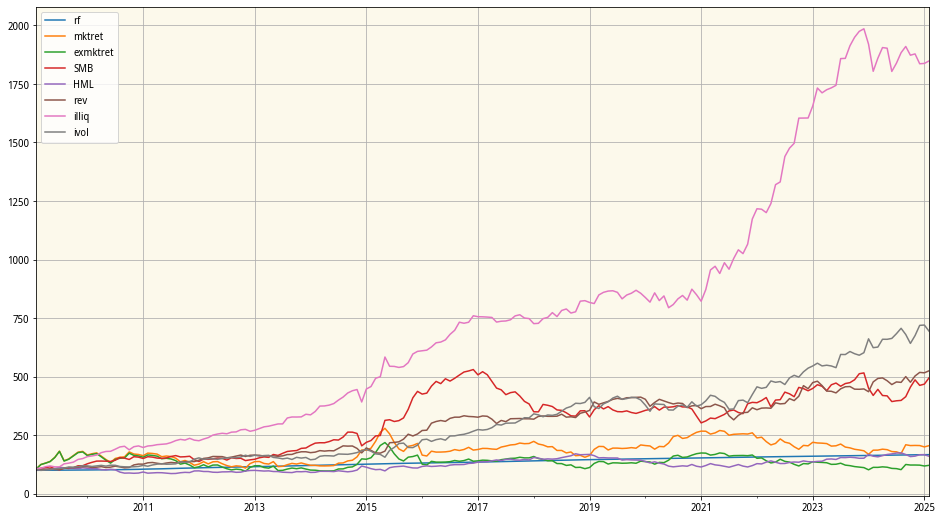

In [186]:
ax = ((factors_df+1).cumprod()*100).plot(grid=True)
ax.set_facecolor("#fcf9eb")
ax.set_xlabel("")
fig = ax.get_figure()
fig.savefig('quant.png',bbox_inches='tight')

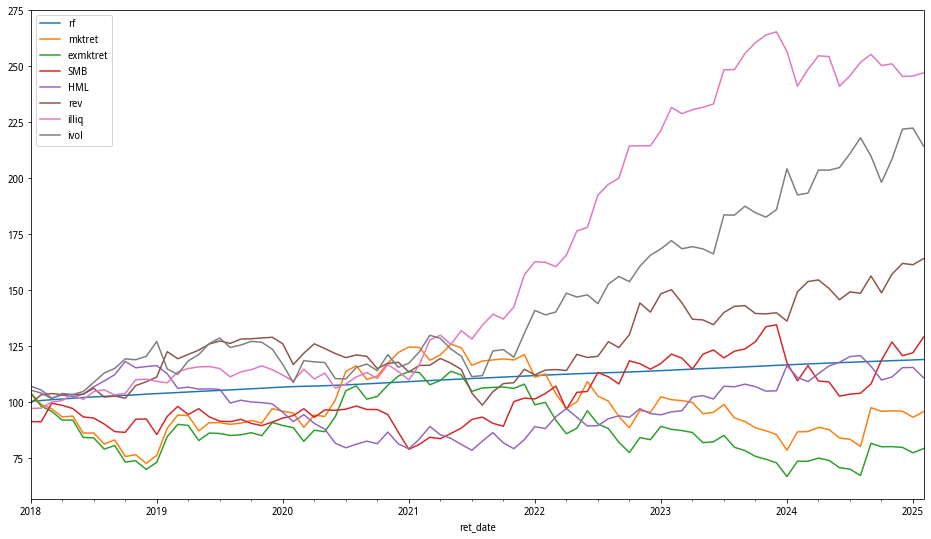

In [187]:
((factors_df['2018':]+1).cumprod()*100).plot()

In [188]:
factors_df.to_pickle('./output_data/factors/factors_all.pkl')

## Output factor exposures

In [189]:
ret_df

secID ret_date  tradeDate       ret        rf     exret  \
0       000001.XSHE  2008-03 2008-02-29 -0.149321  0.002746 -0.152068   
1       000001.XSHE  2008-04 2008-03-31  0.050355  0.002862  0.047493   
2       000001.XSHE  2008-05 2008-04-30 -0.148211  0.002953 -0.151164   
3       000001.XSHE  2008-06 2008-05-30 -0.233848  0.003113 -0.236961   
4       000001.XSHE  2008-07 2008-06-30  0.076047  0.002806  0.073241   
5       000001.XSHE  2008-08 2008-07-31 -0.028846  0.002681 -0.031527   
6       000001.XSHE  2008-09 2008-08-29 -0.257922  0.002889 -0.260811   
7       000001.XSHE  2008-10 2008-09-26 -0.271959  0.002509 -0.274468   
...             ...      ...        ...       ...       ...       ...   
652728  689009.XSHG  2024-10 2024-09-30 -0.080923  0.001517 -0.082440   
652729  689009.XSHG  2024-11 2024-10-31  0.004506  0.001477  0.003029   
652730  689009.XSHG  2024-12 2024-11-29  0.067436  0.001401  0.066035   
652731  689009.XSHG  2025-01 2024-12-31  0.080840  0.001422  0.079419   
652732  689009.XSHG  2025-02 2025-01-27  0.113168  0.001557  0.111611   
652733  689009.XSHG  2025-03 2025-02-28  0.140844  0.001607  0.139237   
652734  689009.XSHG  2025-04 2025-03-31 -0.182671  0.001509 -0.184180   
652735  689009.XSHG      NaT 2025-04-07       NaN       NaN       NaN   

             ym        mktcap       size       rev mom_date       mom    beta  \
0       2008-02  5.823860e+10  24.787814 -0.007450  2008-01       NaN  1.0292   
1       2008-03  4.954234e+10  24.626093 -0.152068  2008-02       NaN  1.0238   
2       2008-04  5.203702e+10  24.675221  0.047493  2008-03       NaN  1.0212   
3       2008-05  4.432458e+10  24.514805 -0.151164  2008-04       NaN  1.0697   
4       2008-06  4.140495e+10  24.446666 -0.236961  2008-05       NaN  1.0672   
5       2008-07  4.455369e+10  24.519961  0.073241  2008-06       NaN  1.0966   
6       2008-08  4.326849e+10  24.490690 -0.031527  2008-07       NaN  1.0386   
7       2008-09  3.210865e+10  24.192391 -0.260811  2008-08       NaN  1.1184   
...         ...           ...        ...       ...      ...       ...     ...   
652728  2024-09  2.633272e+10  23.994078  0.076791  2024-08  0.292420  1.0361   
652729  2024-10  2.420206e+10  23.909704 -0.082440  2024-09  0.480329  1.3022   
652730  2024-11  2.431436e+10  23.914333  0.003029  2024-10  0.347795  1.2585   
652731  2024-12  2.610548e+10  23.985411  0.066035  2024-11  0.510890  1.2255   
652732  2025-01  2.822514e+10  24.063479  0.079419  2024-12  1.049486  1.1695   
652733  2025-02  3.141930e+10  24.170688  0.111611  2025-01  0.706337  1.2526   
652734  2025-03  3.584494e+10  24.302468  0.139237  2025-02  0.921636  1.3115   
652735  2025-04  2.929719e+10  24.100757 -0.184180  2025-03  0.764553  1.5641   

              bm     illiq  illiq_12m       vol      ivol  vol_clip  ivol_clip  
0       0.110009  0.000064        NaN  0.041448       NaN  0.041448        NaN  
1       0.201102  0.000043        NaN  0.045109       NaN  0.045109        NaN  
2       0.206701  0.000051        NaN  0.046323       NaN  0.046323        NaN  
3       0.242665  0.000071        NaN  0.036031       NaN  0.036031        NaN  
4       0.304090  0.000084        NaN  0.041642       NaN  0.041642        NaN  
5       0.282598  0.000083        NaN  0.033244       NaN  0.033244        NaN  
6       0.351136  0.000093        NaN  0.028676       NaN  0.028676        NaN  
7       0.473171  0.000175        NaN  0.053642       NaN  0.053642        NaN  
...          ...       ...        ...       ...       ...       ...        ...  
652728  0.162713  0.000041   0.000103  0.037444  0.021285  0.037444   0.021285  
652729  0.190752  0.000056   0.000091  0.057663  0.020563  0.057663   0.020563  
652730  0.189876  0.000047   0.000088  0.028503  0.018614  0.028503   0.018614  
652731  0.177806  0.000028   0.000080  0.019448  0.016439  0.019448   0.016439  
652732  0.164468  0.000045   0.000069  0.027008  0.022593  0.027008   0.022593  
652733  0.147748  0.00003

In [190]:
ret_df.to_pickle('./output_data/factor_exposure/all_exposure.pkl')

In [191]:
cols = ['size','bm','rev','illiq','ivol']

In [192]:
ret_df[['secID','tradeDate','rev']].dropna().pivot(index='tradeDate',
                                                columns='secID',values='rev')

secID       000001.XSHE  000002.XSHE  000004.XSHE  000005.XSHE  000006.XSHE  \
tradeDate                                                                     
2008-02-29    -0.007450    -0.110432          NaN          NaN     0.012050   
2008-03-17          NaN          NaN          NaN          NaN          NaN   
2008-03-31    -0.152068     0.098329          NaN          NaN    -0.075498   
2008-04-30     0.047493    -0.050908          NaN          NaN     0.118036   
2008-05-30    -0.151164    -0.192531          NaN          NaN    -0.156686   
2008-06-30    -0.236961    -0.268738          NaN          NaN    -0.337022   
2008-07-31     0.073241    -0.059410          NaN    -0.115392     0.107584   
2008-08-29    -0.031527    -0.169740          NaN    -0.226848    -0.263503   
...                 ...          ...          ...          ...          ...   
2025-03-03          NaN          NaN          NaN          NaN          NaN   
2025-03-05          NaN          NaN          NaN          NaN          NaN   
2025-03-17          NaN          NaN          NaN          NaN          NaN   
2025-03-19          NaN          NaN          NaN          NaN          NaN   
2025-03-24          NaN          NaN          NaN          NaN          NaN   
2025-03-25          NaN          NaN          NaN          NaN          NaN   
2025-03-31    -0.025024    -0.091929    -0.195310          NaN     0.141025   
2025-04-07    -0.051243    -0.065339    -0.093918          NaN    -0.141427   

secID       000007.XSHE  000008.XSHE  000009.XSHE  000010.XSHE  000011.XSHE  \
tradeDate                                                                     
2008-02-29          NaN          NaN          NaN          NaN          NaN   
2008-03-17          NaN          NaN          NaN          NaN          NaN   
2008-03-31          NaN          NaN          NaN          NaN          NaN   
2008-04-30          NaN          NaN          NaN          NaN          NaN   
2008-05-30          NaN          NaN          NaN          NaN          NaN   
2008-06-30          NaN          NaN    -0.339632          NaN          NaN   
2008-07-31          NaN          NaN     0.007455          NaN          NaN   
2008-08-29          NaN          NaN    -0.250654          NaN          NaN   
...                 ...          ...          ...          ...          ...   
2025-03-03          NaN          NaN          NaN          NaN          NaN   
2025-03-05          NaN          NaN          NaN          NaN          NaN   
2025-03-17          NaN          NaN          NaN          NaN          NaN   
2025-03-19          NaN          NaN          NaN          NaN          NaN   
2025-03-24          NaN          NaN          NaN          NaN          NaN   
2025-03-25          NaN          NaN          NaN          NaN          NaN   
2025-03-31    -0.025650    -0.080743    -0.053070    -0.008567    -0.000385   
2025-04-07    -0.085244    -0.013230    -0.093994    -0.113403    -0.078426   

secID       ...  688787.XSHG  688788.XSHG  688789.XSHG  688793.XSHG  \
tradeDate   ...                                                       
2008-02-29  ...          NaN          NaN          NaN          NaN   
2008-03-17  ...          NaN          NaN          NaN          NaN   
2008-03-31  ...          NaN          NaN          NaN          NaN   
2008-04-30  ...          NaN          NaN          NaN          NaN   
2008-05-30  ...          NaN          NaN          NaN          NaN   
2008-06-30  ...          NaN          NaN          NaN          NaN   
2008-07-31  ...          NaN          NaN          NaN          NaN   
2008-08-29  ...          NaN          NaN          NaN          NaN   
...         ...          ...          ...          ...          ...   
2025-03-03  ...          NaN          NaN          NaN          NaN   
2025-03-05  ...          NaN          NaN          NaN          NaN   
2025-03-17  ...          NaN          NaN          NaN          NaN   
20

In [193]:
temp = ret_df[['secID','tradeDate','size']].dropna().pivot(index='tradeDate',
                                                columns='secID',values='size').reset_index()
temp['tradeDate'] = temp['tradeDate'].dt.strftime('%Y/%m/%d')
temp.set_index('tradeDate')

secID       000001.XSHE  000002.XSHE  000004.XSHE  000005.XSHE  000006.XSHE  \
tradeDate                                                                     
2008/02/29    24.787814    25.641710          NaN          NaN    22.532210   
2008/03/17          NaN          NaN          NaN          NaN          NaN   
2008/03/31    24.626093    25.737997          NaN          NaN    22.456673   
2008/04/30    24.675221    25.688758          NaN          NaN    22.566844   
2008/05/30    24.514805    25.478559          NaN          NaN    22.399923   
2008/06/30    24.446666    25.163784          NaN    21.746966    21.993592   
2008/07/31    24.519961    25.105515          NaN    21.627546    22.098303   
2008/08/29    24.490690    24.922723          NaN    21.374857    21.796091   
...                 ...          ...          ...          ...          ...   
2025/03/03          NaN          NaN          NaN          NaN          NaN   
2025/03/05          NaN          NaN          NaN          NaN          NaN   
2025/03/17          NaN          NaN          NaN          NaN          NaN   
2025/03/19          NaN          NaN          NaN          NaN          NaN   
2025/03/24          NaN          NaN          NaN          NaN          NaN   
2025/03/25          NaN          NaN          NaN          NaN          NaN   
2025/03/31    26.110083    24.950164    20.930317          NaN    23.009865   
2025/04/07    26.059070    24.884206    20.833363          NaN    22.859137   

secID       000007.XSHE  000008.XSHE  000009.XSHE  000010.XSHE  000011.XSHE  \
tradeDate                                                                     
2008/02/29          NaN          NaN          NaN          NaN          NaN   
2008/03/17          NaN          NaN          NaN          NaN          NaN   
2008/03/31          NaN          NaN          NaN          NaN          NaN   
2008/04/30          NaN          NaN          NaN          NaN          NaN   
2008/05/30          NaN          NaN    22.423595          NaN          NaN   
2008/06/30          NaN          NaN    22.013350          NaN          NaN   
2008/07/31          NaN          NaN    22.023565          NaN          NaN   
2008/08/29          NaN          NaN    21.738589          NaN          NaN   
...                 ...          ...          ...          ...          ...   
2025/03/03          NaN          NaN          NaN          NaN          NaN   
2025/03/05          NaN          NaN          NaN          NaN          NaN   
2025/03/17          NaN          NaN          NaN          NaN          NaN   
2025/03/19          NaN          NaN          NaN          NaN          NaN   
2025/03/24          NaN          NaN          NaN          NaN          NaN   
2025/03/25          NaN          NaN          NaN          NaN          NaN   
2025/03/31    21.469891    22.651335    23.753018    21.131541    22.200378   
2025/04/07    21.382432    22.639547    23.655980    21.012883    22.120335   

secID       ...  688787.XSHG  688788.XSHG  688789.XSHG  688793.XSHG  \
tradeDate   ...                                                       
2008/02/29  ...          NaN          NaN          NaN          NaN   
2008/03/17  ...          NaN          NaN          NaN          NaN   
2008/03/31  ...          NaN          NaN          NaN          NaN   
2008/04/30  ...          NaN          NaN          NaN          NaN   
2008/05/30  ...          NaN          NaN          NaN          NaN   
2008/06/30  ...          NaN          NaN          NaN          NaN   
2008/07/31  ...          NaN          NaN          NaN          NaN   
2008/08/29  ...          NaN          NaN          NaN          NaN   
...         ...          ...          ...          ...          ...   
2025/03/03  ...          NaN          NaN          NaN          NaN   
2025/03/05  ...          NaN          NaN          NaN          NaN   
2025/03/17  ...          NaN          NaN          NaN          NaN   
20

In [194]:
for c in cols:
    temp = ret_df[['secID','tradeDate',c]].dropna().pivot(index='tradeDate',columns='secID',values=c)
    temp.reset_index(inplace=True)
    temp['tradeDate'] = temp['tradeDate'].dt.strftime('%Y/%m/%d')
    temp.set_index('tradeDate',inplace=True)
    temp.to_csv(f'./output_data/factor_exposure/{c}_exposure.csv')

## Long-only ivol factor

In [195]:
factors_daily = pd.read_pickle('./output_data/factors/factors_daily_long_only.pkl')
illiq_daily = daily_factor(ret_df, stock_df=stk_df,sort1='illiq',long_only=True)
illiq_daily.name = 'illiq_long'
factors_daily = pd.merge(factors_daily, illiq_daily, on='tradeDate')

In [196]:
reg_df = pd.merge(stk_df[['secID','tradeDate','ret_daily']],factors_daily,
                  on=['tradeDate'])
reg_df.sort_values(['secID','tradeDate'],inplace=True)
reg_df['exret'] = reg_df['ret_daily'] - reg_df['rf']
reg_df['ym'] = reg_df['tradeDate'].dt.to_period('M')

In [197]:
reg_df.set_index('ym',inplace=True)

In [198]:
reg_df

secID  tradeDate  ret_daily        rf    mktret  exmktret  \
ym                                                                         
2008-03  000001.XSHE 2008-03-03  -0.004525  0.000067  0.026897  0.026830   
2008-03  000001.XSHE 2008-03-04  -0.098485  0.000053 -0.020697 -0.020750   
2008-03  000001.XSHE 2008-03-05  -0.011429  0.000053 -0.005939 -0.005992   
2008-03  000001.XSHE 2008-03-06   0.030262  0.000053  0.009690  0.009637   
2008-03  000001.XSHE 2008-03-07  -0.019802  0.000053 -0.015218 -0.015271   
2008-03  000001.XSHE 2008-03-10  -0.074074  0.000053 -0.039153 -0.039206   
2008-03  000001.XSHE 2008-03-11  -0.018546  0.000052  0.004897  0.004845   
2008-03  000001.XSHE 2008-03-12  -0.040385  0.000052 -0.028964 -0.029016   
...              ...        ...        ...       ...       ...       ...   
2025-03  689009.XSHG 2025-03-26  -0.000160  0.000049 -0.002362 -0.002411   
2025-03  689009.XSHG 2025-03-27   0.053222  0.000048  0.002859  0.002811   
2025-03  689009.XSHG 2025-03-28  -0.002296  0.000047 -0.005064 -0.005111   
2025-03  689009.XSHG 2025-03-31   0.000762  0.000048 -0.007829 -0.007877   
2025-04  689009.XSHG 2025-04-01  -0.019007  0.000050  0.001633  0.001583   
2025-04  689009.XSHG 2025-04-02  -0.004068  0.000048 -0.000349 -0.000397   
2025-04  689009.XSHG 2025-04-03  -0.010990  0.000044 -0.006728 -0.006772   
2025-04  689009.XSHG 2025-04-07  -0.154136  0.000049 -0.077013 -0.077062   

         size_long   bm_long  mom_long  rev_long  illiq_long     exret  
ym                                                                      
2008-03   0.034565  0.028861       NaN  0.026900    0.029310 -0.004592  
2008-03  -0.003891 -0.013102       NaN -0.015996   -0.008660 -0.098538  
2008-03   0.009921  0.004250       NaN -0.000938    0.002925 -0.011482  
2008-03   0.003635  0.007741       NaN  0.013003    0.005033  0.030209  
2008-03  -0.020267 -0.021297       NaN -0.013844   -0.017904 -0.019855  
2008-03  -0.029493 -0.032543       NaN -0.032828   -0.030760 -0.074127  
2008-03   0.017306  0.012769       NaN  0.007614    0.007745 -0.018598  
2008-03  -0.024126 -0.025740       NaN -0.027242   -0.022307 -0.040438  
...            ...       ...       ...       ...         ...       ...  
2025-03   0.013893  0.006590  0.007079  0.005925    0.012145 -0.000209  
2025-03  -0.006631 -0.003529 -0.000978 -0.001411   -0.002950  0.053174  
2025-03  -0.016197 -0.011299 -0.011874 -0.010924   -0.010709 -0.002344  
2025-03  -0.012221 -0.010069 -0.005526 -0.009002   -0.008520  0.000714  
2025-04   0.014661  0.010446  0.000826  0.005083    0.015131 -0.019057  
2025-04   0.002379  0.001605  0.004119  0.002258    0.002772 -0.004116  
2025-04  -0.004158  0.002851 -0.010769 -0.009784   -0.003835 -0.011034  
2025-04  -0.127854 -0.089972 -0.112886 -0.121024   -0.113549 -0.154185  

[13131596 rows x 12 columns]

In [199]:
gc.collect()

1197

In [200]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

               stk_unfilled_df:  3.0 GiB
                          _129:  2.0 GiB
                          _131:  2.0 GiB
                          _154:  2.0 GiB
                            __:  2.0 GiB
                        reg_df:  2.0 GiB
                          _198:  2.0 GiB
                       beta_df:  1.9 GiB
                        stk_df:  1.8 GiB
                           _22:  1.8 GiB


In [201]:
del stk_unfilled_df, beta_df

In [202]:
del _129

In [203]:
del _131, _154, __, _198, _22

In [204]:
# %%time
# ivol = reg_df.groupby(['secID']).apply(idiovol_np, factor_cols=['exmktret','size_long','bm_long','mom_long','rev_long','illiq_long'])
# # Takes about 47min 25s to execute

CPU times: user 46min 21s, sys: 51.4 s, total: 47min 13s
Wall time: 47min 20s


In [205]:
# ivol = ivol.reset_index().drop('level_1',axis=1)
# display(ivol)
# ivol.to_pickle('./data/idiovol1m_long_only.pkl')

secID       ym  idiovol1m
0       000001.XSHE  2008-03        NaN
1       000001.XSHE  2008-04        NaN
2       000001.XSHE  2008-05        NaN
3       000001.XSHE  2008-06        NaN
4       000001.XSHE  2008-07        NaN
5       000001.XSHE  2008-08        NaN
6       000001.XSHE  2008-09        NaN
7       000001.XSHE  2008-10        NaN
...             ...      ...        ...
655205  689009.XSHG  2024-09   0.019224
655206  689009.XSHG  2024-10   0.027237
655207  689009.XSHG  2024-11   0.018958
655208  689009.XSHG  2024-12   0.014907
655209  689009.XSHG  2025-01   0.022738
655210  689009.XSHG  2025-02   0.027984
655211  689009.XSHG  2025-03   0.017331
655212  689009.XSHG  2025-04        NaN

[655213 rows x 3 columns]

In [206]:
vol_df = stk_df.groupby(['secID','ym'])['ret_daily'].std()
vol_df = vol_df.to_frame()
vol_df.columns = ['vol']
vol_df.reset_index(inplace=True)
MIN_NOBS = 15
idx = stk_df.groupby(['secID','ym'],as_index=False)['tradeDate'].count()['tradeDate'] < MIN_NOBS
vol_df.loc[idx, 'vol'] = np.nan

In [207]:
ivol = pd.read_pickle('./data/idiovol1m_long_only.pkl')
vol_df = pd.merge(vol_df,ivol,on=['secID','ym'])
vol_df['vol_clip'] = vol_df['vol'].clip(lower=vol_df['vol'].quantile(0.001),
                                        upper=vol_df['vol'].quantile(0.999))
vol_df['ivol_clip'] = vol_df['idiovol1m'].clip(lower=vol_df['idiovol1m'].quantile(0.001),
                                               upper=vol_df['idiovol1m'].quantile(0.999))
vol_df.rename(columns={'idiovol1m':'ivol'},inplace=True)

In [208]:
try:
    ret_df.drop(['vol','ivol','vol_clip','ivol_clip'],axis=1,inplace=True)
except KeyError:
    pass

In [209]:
ret_df = pd.merge(ret_df,vol_df,
                  on=['secID','ym'])

In [210]:
ret_df

secID ret_date  tradeDate       ret        rf     exret  \
0       000001.XSHE  2008-04 2008-03-31  0.050355  0.002862  0.047493   
1       000001.XSHE  2008-05 2008-04-30 -0.148211  0.002953 -0.151164   
2       000001.XSHE  2008-06 2008-05-30 -0.233848  0.003113 -0.236961   
3       000001.XSHE  2008-07 2008-06-30  0.076047  0.002806  0.073241   
4       000001.XSHE  2008-08 2008-07-31 -0.028846  0.002681 -0.031527   
5       000001.XSHE  2008-09 2008-08-29 -0.257922  0.002889 -0.260811   
6       000001.XSHE  2008-10 2008-09-26 -0.271959  0.002509 -0.274468   
7       000001.XSHE  2008-11 2008-10-31  0.074075  0.001903  0.072172   
...             ...      ...        ...       ...       ...       ...   
651377  689009.XSHG  2024-10 2024-09-30 -0.080923  0.001517 -0.082440   
651378  689009.XSHG  2024-11 2024-10-31  0.004506  0.001477  0.003029   
651379  689009.XSHG  2024-12 2024-11-29  0.067436  0.001401  0.066035   
651380  689009.XSHG  2025-01 2024-12-31  0.080840  0.001422  0.079419   
651381  689009.XSHG  2025-02 2025-01-27  0.113168  0.001557  0.111611   
651382  689009.XSHG  2025-03 2025-02-28  0.140844  0.001607  0.139237   
651383  689009.XSHG  2025-04 2025-03-31 -0.182671  0.001509 -0.184180   
651384  689009.XSHG      NaT 2025-04-07       NaN       NaN       NaN   

             ym        mktcap       size       rev mom_date       mom    beta  \
0       2008-03  4.954234e+10  24.626093 -0.152068  2008-02       NaN  1.0238   
1       2008-04  5.203702e+10  24.675221  0.047493  2008-03       NaN  1.0212   
2       2008-05  4.432458e+10  24.514805 -0.151164  2008-04       NaN  1.0697   
3       2008-06  4.140495e+10  24.446666 -0.236961  2008-05       NaN  1.0672   
4       2008-07  4.455369e+10  24.519961  0.073241  2008-06       NaN  1.0966   
5       2008-08  4.326849e+10  24.490690 -0.031527  2008-07       NaN  1.0386   
6       2008-09  3.210865e+10  24.192391 -0.260811  2008-08       NaN  1.1184   
7       2008-10  2.330715e+10  23.872026 -0.274468  2008-09       NaN  1.1991   
...         ...           ...        ...       ...      ...       ...     ...   
651377  2024-09  2.633272e+10  23.994078  0.076791  2024-08  0.292420  1.0361   
651378  2024-10  2.420206e+10  23.909704 -0.082440  2024-09  0.480329  1.3022   
651379  2024-11  2.431436e+10  23.914333  0.003029  2024-10  0.347795  1.2585   
651380  2024-12  2.610548e+10  23.985411  0.066035  2024-11  0.510890  1.2255   
651381  2025-01  2.822514e+10  24.063479  0.079419  2024-12  1.049486  1.1695   
651382  2025-02  3.141930e+10  24.170688  0.111611  2025-01  0.706337  1.2526   
651383  2025-03  3.584494e+10  24.302468  0.139237  2025-02  0.921636  1.3115   
651384  2025-04  2.929719e+10  24.100757 -0.184180  2025-03  0.764553  1.5641   

              bm     illiq  illiq_12m       vol      ivol  vol_clip  ivol_clip  
0       0.201102  0.000043        NaN  0.045109       NaN  0.045109        NaN  
1       0.206701  0.000051        NaN  0.046323       NaN  0.046323        NaN  
2       0.242665  0.000071        NaN  0.036031       NaN  0.036031        NaN  
3       0.304090  0.000084        NaN  0.041642       NaN  0.041642        NaN  
4       0.282598  0.000083        NaN  0.033244       NaN  0.033244        NaN  
5       0.351136  0.000093        NaN  0.028676       NaN  0.028676        NaN  
6       0.473171  0.000175        NaN  0.053642       NaN  0.053642        NaN  
7       0.706914  0.000144   0.000084  0.051112       NaN  0.051112        NaN  
...          ...       ...        ...       ...       ...       ...        ...  
651377  0.162713  0.000041   0.000103  0.037444  0.019224  0.037444   0.019224  
651378  0.190752  0.000056   0.000091  0.057663  0.027237  0.057663   0.027237  
651379  0.189876  0.000047   0.000088  0.028503  0.018958  0.028503   0.018958  
651380  0.177806  0.000028   0.000080  0.019448  0.014907  0.019448   0.014907  
651381  0.164468  0.000045   0.000069  0.027008  0.022738  0.027008   0.022738  
651382  0.147748  0.00003

In [211]:
# ivol.loc[ivol['ym']=='2015-09'].describe()

# temp = ivol.loc[ivol['ym']=='2015-09']

# temp.loc[temp['idiovol1m'].idxmin()]

# temp['secID']

# temp.loc[temp['idiovol1m'] <= temp['idiovol1m'].quantile(0.11)]

# ret_df.loc[ret_df['ret_date']=='2015-10']

# q = dict()
# keys = ['q'+str(i) for i in range(1, 10)]
# values = np.arange(0.1, 1.0, 0.1)
# q.update(zip(keys,values))

# quantile_df = pd.DataFrame()
# for key, value in q.items():
#     quantile_df[key] = ret_df.groupby(['ym'])['ivol'].quantile(value)

# df_q = pd.merge(ret_df, quantile_df, on='ym')

# portfolios = dict()
# drop_cols = [col for col in df_q.columns if col[0]=='q']

# portfolios['p1'] = df_q.loc[df_q['ivol'] <= df_q['q1']].copy().drop(drop_cols, axis=1)
# for i in range(2,10):
#     idx = (df_q[f'q{i-1}'] <= df_q['ivol']) & (df_q['ivol'] <= df_q[f'q{i}'])
#     portfolios[f'p{i}'] = df_q.loc[idx].copy().drop(drop_cols, axis=1)
# portfolios['p10'] = df_q.loc[df_q['ivol'] >= df_q['q9']].copy().drop(drop_cols, axis=1)

# pf_n_stks.loc[pd.Period('2015-08'):pd.Period('2015-12')]

# ret_df.loc[ret_df['ym']=='2015-10']

# df_q.loc[df_q['ret_date']=='2015-10']

# pf_n_stks = pd.DataFrame()
# for key, value in portfolios.items():
#     pf_n_stks[key] = portfolios[key].groupby('ret_date')['secID'].nunique()

# display(pf_n_stks)

# pf_n_stks.plot()

# portfolios['p1'].loc[portfolios['p1']['ret_date']=='2015-10']

# def single_sort(df, sort):
#     q = dict()
#     keys = ['q'+str(i) for i in range(1, 10)]
#     values = np.arange(0.1, 1.0, 0.1)
#     q.update(zip(keys,values))

#     quantile_df = pd.DataFrame()
#     for key, value in q.items():
#         quantile_df[key] = df.groupby(['ym'])[sort].quantile(value)

#     df_q = pd.merge(df, quantile_df, on='ym')

#     portfolios = dict()
#     drop_cols = [col for col in df_q.columns if col[0]=='q']

#     portfolios['p1'] = df_q.loc[df_q[sort] <= df_q['q1']].copy().drop(drop_cols, axis=1)
#     for i in range(2,10):
#         idx = (df_q[f'q{i-1}'] <= df_q[sort]) & (df_q[sort] <= df_q[f'q{i}'])
#         portfolios[f'p{i}'] = df_q.loc[idx].copy().drop(drop_cols, axis=1)
#     portfolios['p10'] = df_q.loc[df_q[sort] >= df_q['q9']].copy().drop(drop_cols, axis=1)

#     portfolios_crs_mean = dict()
#     for k in portfolios.keys():
#         portfolios_crs_mean[k] = portfolios[k].groupby(['ret_date'])['exret'].mean()

#     mean_values = {}
#     t_values = {}
#     for k in portfolios_crs_mean.keys():
#         y = portfolios_crs_mean[k]
#         const = np.full(shape=len(y),fill_value=1)
#         reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
#         mean_values[k] = reg.params[0]
#         t_values[k] = reg.tvalues[0]
#     # Portfolio 10-1
#     y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
#     const = np.full(shape=len(y), fill_value=1)
#     reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
#     mean_values['p10-p1'] = reg.params[0]
#     t_values['p10-p1'] = reg.tvalues[0]
#     print(y.loc[y.isna()])
# #     print(portfolios_crs_mean['p10'].loc[portfolios_crs_mean['p10'].isna()])
# #     print(portfolios_crs_mean['p1'].loc[portfolios_crs_mean['p1'].isna()])
#     print(portfolios_crs_mean['p10'].loc[pd.Period('2015-10')])
# #     print(portfolios_crs_mean['p1'].loc[pd.Period('2015-10')])
#     print(portfolios_crs_mean['p1'].loc[pd.Period('2015-09'):pd.Period('2015-12')])
    
#     display(pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
#                  columns=mean_values.keys()))

In [212]:
single_sort(ret_df, 'ivol_clip')

p1        p2        p3        p4        p5        p6        p7  \
mean     0.014645  0.014209  0.014931  0.013418  0.013274  0.011831  0.009052   
t-value  2.341461  2.541835  2.682102  2.516761  2.410651  2.180104  1.717565   

               p8        p9       p10    p10-p1  
mean     0.007138  0.003754 -0.004701 -0.019346  
t-value  1.271308  0.664582 -0.758943 -7.127658

In [213]:
cols = ['beta','size','bm','mom','rev','illiq','ivol_clip']
temp = ret_df.groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)

# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept      beta      size        bm       mom       rev  \
ret_mean   0.075374  0.002727 -0.002877  0.001453  0.002517 -0.024767   
t_values   2.330998  0.859520 -2.251299  0.366234  1.004622 -3.278946   

              illiq  ivol_clip  
ret_mean  11.040750  -0.672423  
t_values   5.652196  -9.775895

In [214]:
ivol_factor = factor(ret_df, sort1='ivol',long_high=False,long_only=True)

In [215]:
factors_long_df = pd.merge(factors_long_df,ivol_factor,on='ret_date',how='left')

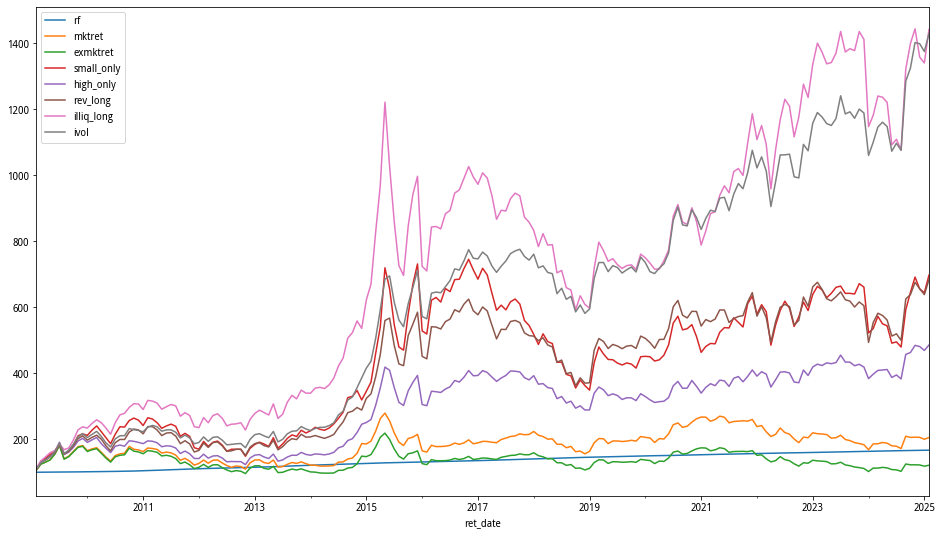

In [216]:
((factors_long_df+1).cumprod()*100).plot()

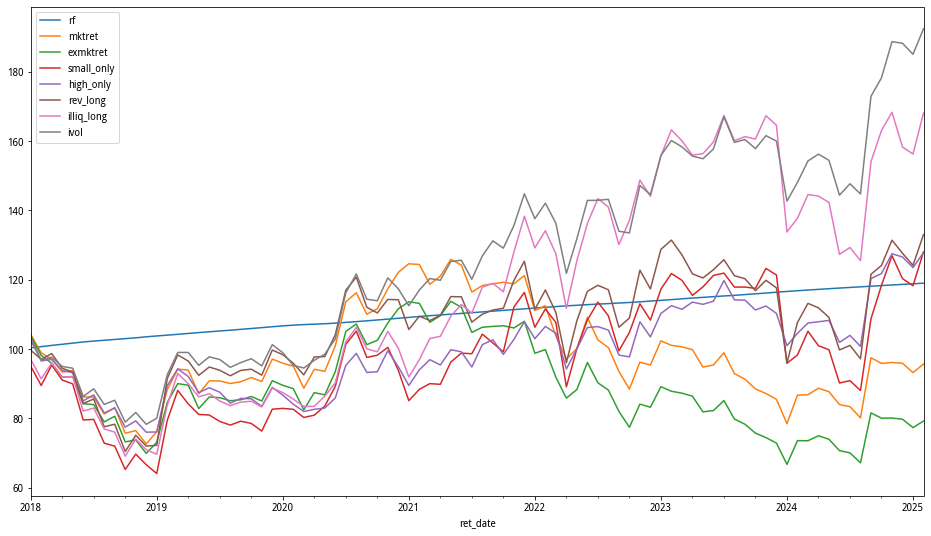

In [217]:
((factors_long_df['2018':]+1).cumprod()*100).plot()

In [218]:
factors_long_df.rename(columns={'ivol':'ivol_long'},inplace=True)

In [219]:
factors_long_df

rf    mktret  exmktret  small_only  high_only  rev_long  \
ret_date                                                                  
2009-02   0.000862  0.058710  0.057622    0.085430   0.084536  0.073752   
2009-03   0.000857  0.178938  0.177897    0.229977   0.192277  0.222602   
2009-04   0.000855  0.048803  0.047790    0.069577   0.062876  0.055581   
2009-05   0.000856  0.054285  0.053275    0.080352   0.064899  0.076523   
2009-06   0.001084  0.126314  0.125271    0.051901   0.097641  0.069063   
2009-07   0.001461  0.170935  0.169708    0.138242   0.188059  0.154281   
2009-08   0.001339 -0.226937 -0.228372   -0.149964  -0.194644 -0.157652   
2009-09   0.001453  0.056478  0.055019    0.038860   0.047223  0.057072   
...            ...       ...       ...         ...        ...       ...   
2024-07   0.001529 -0.007093 -0.009161    0.007591   0.019830  0.013166   
2024-08   0.001518 -0.038931 -0.040999   -0.031232  -0.030772 -0.038172   
2024-09   0.001517  0.216653  0.214585    0.234804   0.194438  0.250951   
2024-10   0.001517 -0.016745 -0.018813    0.089019   0.012109  0.020915   
2024-11   0.001477  0.002654  0.000586    0.072314   0.046916  0.058723   
2024-12   0.001401 -0.002120 -0.004188   -0.052170  -0.007315 -0.028781   
2025-01   0.001422 -0.028387 -0.030455   -0.017141  -0.024264 -0.027236   
2025-02   0.001557  0.026599  0.024531    0.082804   0.034944  0.071393   

          illiq_long  ivol_long  
ret_date                         
2009-02     0.115851   0.084620  
2009-03     0.200210   0.192241  
2009-04     0.093751   0.062928  
2009-05     0.088026   0.067950  
2009-06     0.040224   0.110376  
2009-07     0.122264   0.156728  
2009-08    -0.094146  -0.167855  
2009-09     0.030009   0.065515  
...              ...        ...  
2024-07     0.015501   0.022718  
2024-08    -0.029232  -0.019847  
2024-09     0.227407   0.194712  
2024-10     0.058582   0.030857  
2024-11     0.032086   0.058561  
2024-12    -0.059452  -0.002475  
2025-01    -0.012925  -0.016920  
2025-02     0.075730   0.039756  

[193 rows x 8 columns]

In [220]:
factors_long_df.to_pickle('./output_data/factors/factors_all_long_only.pkl')

In [ ]:

\